In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import xgboost as xgb
import itertools
import warnings
from matplotlib.lines import Line2D
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import ElasticNet
import seaborn as sns
from statsmodels.tsa.statespace.sarimax import SARIMAX
import pandas as pd
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
import pandas as pd
from statsmodels.tsa.statespace.sarimax import SARIMAX
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import adfuller
from scipy.stats import boxcox


# Checking data 

In [6]:
# Load data
df = pd.read_csv(r"C:\Users\dylan\OneDrive - HvA\AAI Master\BLOK 3 afstuderen\Thesis\Eigenwerk\DATASET\AVG_Gas.csv")
# Set datetime as index and assign frequency
# df = df.set_index("Time Period (T)")
# df.index.freq = "MS"  # Assuming monthly data


df["Time Period (T)"] = pd.to_datetime(df["Time Period (T)"], format="%Y-%m-%d")
df = df.sort_values("Time Period (T)").reset_index(drop=True)
display(df.head())

,Time Period (T),Home charging (G),Electric car (G),Hybrid electric (G),Company car tax rate (%),Consumer confidence (E),Economic climate perception (E),Willingness to buy (E),Major purchases sentiment (E),Gasoline (Euro95) - Average price (F),Diesel - Average price (F),Total vehicles sold (Target)
0,2007-01-01,0,1,0,22,20.0,37.0,9.0,8.0,1.303032,0.970000,31
1,2007-02-01,0,0,0,22,20.0,37.0,9.0,8.0,1.325357,0.990000,39
2,2007-03-01,0,0,0,22,20.0,37.0,9.0,8.0,1.379032,1.006323,123
3,2007-04-01,0,0,0,22,20.0,37.0,9.0,8.0,1.426500,1.030600,62
4,2007-05-01,0,2,0,22,18.0,32.0,9.0,7.4,1.466516,1.032323,84


# Exploring PCA from dataset 

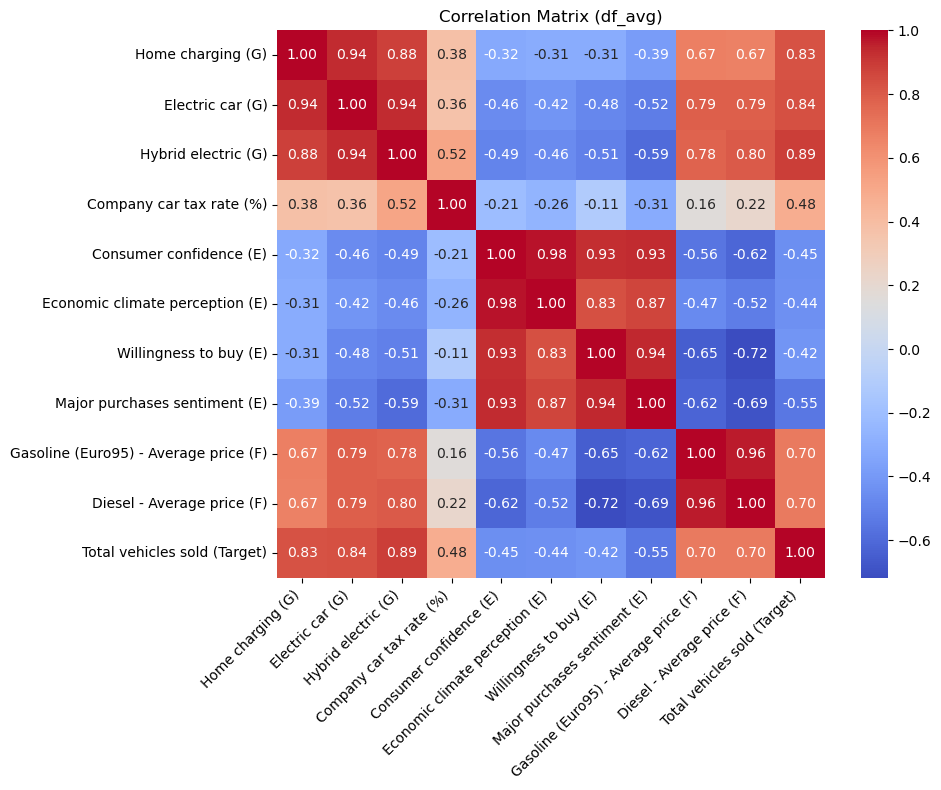

In [3]:
# Compute correlation matrix for df_avg
corr_matrix_avg = df.select_dtypes(include=['number']).corr()

# Plot correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix_avg, annot=True, fmt=".2f", cmap="coolwarm", square=True)
plt.title("Correlation Matrix (df_avg)")
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()
plt.show()

> looking at the data we see that the top 5 rows are as follows:

# Data workflow

## PLot target variable

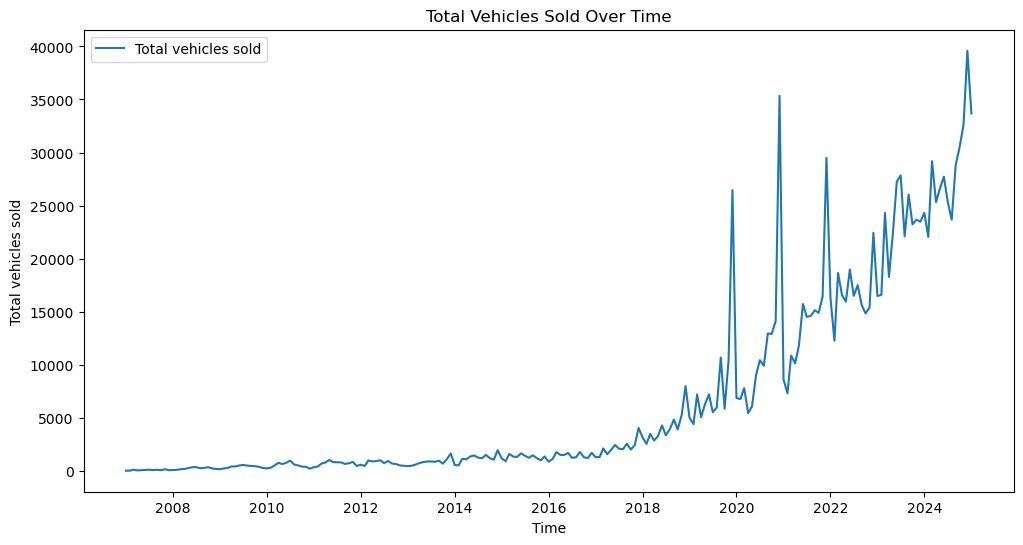

In [7]:
plt.figure(figsize=(12, 6))
plt.plot(df["Time Period (T)"], df["Total vehicles sold (Target)"], label="Total vehicles sold")
plt.xlabel("Time")
plt.ylabel("Total vehicles sold")
plt.title("Total Vehicles Sold Over Time")
plt.legend()
plt.show()

> Alot of varience, lets add box cox 

Optimal lambda for Box-Cox: -0.0021


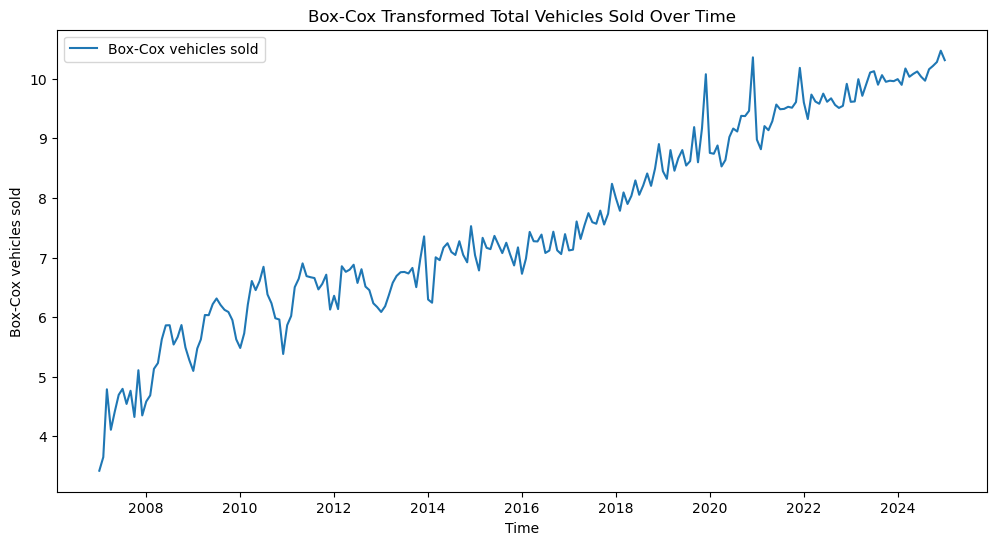

In [8]:


# Select the target column
target_col = 'Total vehicles sold (Target)'
y = df[target_col].values

# Box-Cox requires all values > 0
if (y <= 0).any():
    raise ValueError("Box-Cox transformation requires all values to be positive.")

# Perform Box-Cox transformation
y_boxcox, fitted_lambda = boxcox(y)

# Add transformed values to the dataframe
df['BoxCox vehicles sold (Target)'] = y_boxcox

print(f"Optimal lambda for Box-Cox: {fitted_lambda:.4f}")

plt.figure(figsize=(12, 6))
plt.plot(df["Time Period (T)"], y_boxcox, label="Box-Cox vehicles sold")
plt.xlabel("Time")
plt.ylabel("Box-Cox vehicles sold")
plt.title("Box-Cox Transformed Total Vehicles Sold Over Time")
plt.legend()
plt.show()



Little les varience 

### Check for stationality

The variencie is much better now, however there is still an upward trend and some seasonality visable in the data, to test the stationality i will performing a unit root test. 

there are several unit root tests available, such as the Augmented Dickey-Fuller (ADF) test, the Kwiatkowski-Phillips-Schmidt-Shin (KPSS) test, and the Phillips-Perron (PP) test. I will be using the ADF test, which is a widely used test for stationarity in time series data. 

In [9]:

# Perform Augmented Dickey-Fuller test on the BoxCox-transformed target
result = adfuller(df['BoxCox vehicles sold (Target)'])

print("ADF Statistic: {:.4f}".format(result[0]))
print("p-value: {:.4f}".format(result[1]))
for key, value in result[4].items():
    print(f"Critical Value ({key}): {value:.4f}")

if result[1] < 0.05:
    print("The series is likely stationary (reject H0).")
else:
    print("The series is likely non-stationary (fail to reject H0).")

ADF Statistic: -0.8015
p-value: 0.8187
Critical Value (1%): -3.4630
Critical Value (5%): -2.8759
Critical Value (10%): -2.5744
The series is likely non-stationary (fail to reject H0).


> With an ADF statistic of -0.8015, and a high p-value of 0.8187, we have failed to reject the null hypothesis meaning the series still likely contains a unit root (i.e. it's non-stationary) even after applying Box-Cox.

my next step is to apply a first difference to the data to remove the trend, and then re-evaluate stationarity using the ADF test again.

### Apply first difference

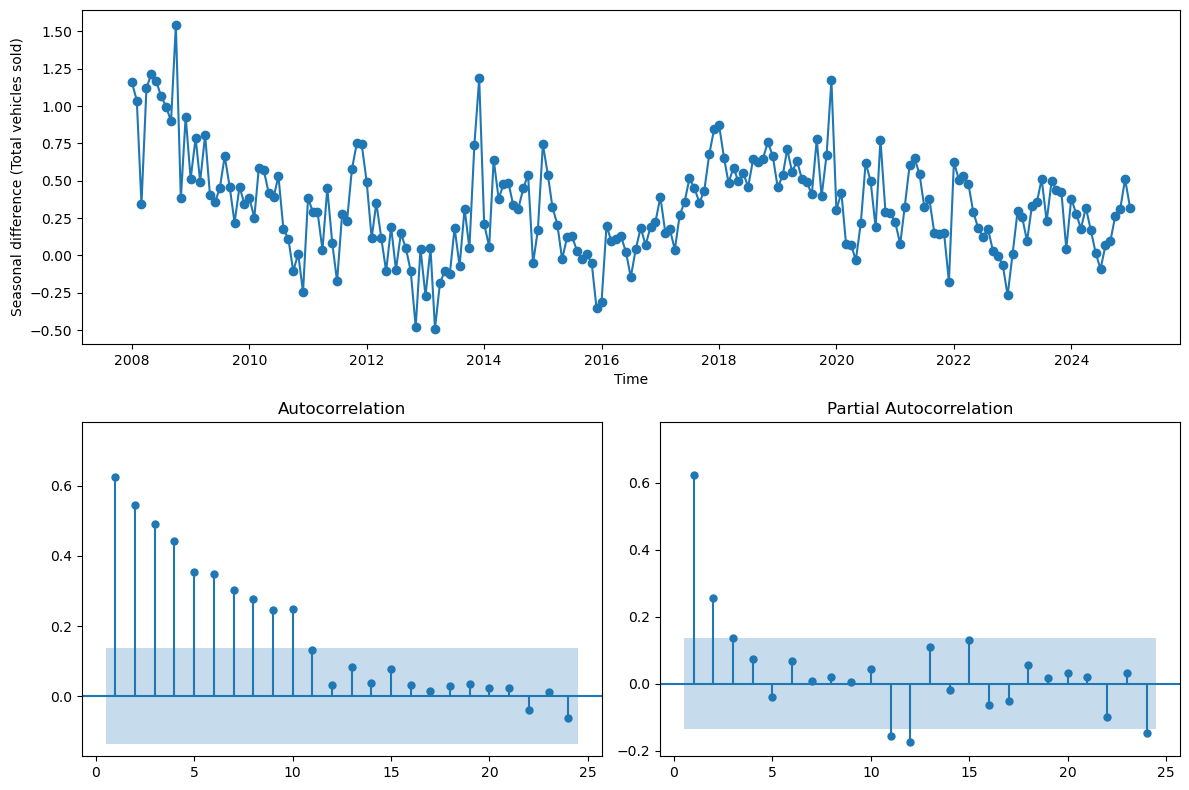

ADF Statistic (seasonal differenced): -3.5399
p-value: 0.0070
Critical Value (1%): -3.4649
Critical Value (5%): -2.8767
Critical Value (10%): -2.5749
The series is likely stationary (reject H0).


In [10]:
# Calculate 12-lag (seasonal) difference of the target variable
seasonal_diff = df["BoxCox vehicles sold (Target)"].diff(12).dropna()

fig = plt.figure(figsize=(12, 8))
gs = fig.add_gridspec(2, 2)
ax1 = fig.add_subplot(gs[0, :])
ax2 = fig.add_subplot(gs[1, 0])
ax3 = fig.add_subplot(gs[1, 1])

ax1.plot(df["Time Period (T)"].iloc[12:], seasonal_diff, marker="o")
ax1.set_ylabel("Seasonal difference (Total vehicles sold)")
ax1.set_xlabel("Time")

plot_acf(seasonal_diff, ax2, zero=False, lags=24, bartlett_confint=False, auto_ylims=True)
plot_pacf(seasonal_diff, ax3, zero=False, lags=24, auto_ylims=True)
plt.tight_layout()
plt.show()

# Perform Augmented Dickey-Fuller test on the seasonal differenced data
adf_result = adfuller(seasonal_diff)

print("ADF Statistic (seasonal differenced): {:.4f}".format(adf_result[0]))
print("p-value: {:.4f}".format(adf_result[1]))
for key, value in adf_result[4].items():
    print(f"Critical Value ({key}): {value:.4f}")

if adf_result[1] < 0.05:
    print("The series is likely stationary (reject H0).")
else:
    print("The series is likely non-stationary (fail to reject H0).")





ACF Plot Interpretation:
The ACF plot shows a significant spike at lag 1, followed by a gradual decay. This pattern is characteristic of a non-seasonal MA(1) process. Additionally, there's a prominent spike at lag 12, suggesting a seasonal component at the yearly level (monthly data), indicative of seasonal MA(1).

PACF Plot Interpretation:
The PACF plot shows a strong spike at lag 1, and a possible smaller spike at lag 2, followed by a sharp decline. This pattern supports the presence of a non-seasonal AR(1) or possibly AR(2) term. A clear spike at lag 12 also appears in the PACF, followed by mild decay, suggesting a seasonal AR(1) component.

Suggested Model:
Based on the ACF and PACF patterns, a suitable model would be:
SARIMA(1,1,1)(1,1,1)[12]


In [12]:

# Split data: 80% train, 10% validation, 10% test
n = len(df)
train_end = int(n * 0.8)
val_end = int(n * 0.9)

train = df.iloc[:train_end]
val = df.iloc[train_end:val_end]
test = df.iloc[val_end:]

# Define your model configurations
model_configs = {
    "SARIMA(1,0,1)(0,1,1)[12]": {"order": (1, 0, 1), "seasonal_order": (0, 1, 1, 12)},
    "SARIMA(2,0,1)(0,1,1)[12]": {"order": (2, 0, 1), "seasonal_order": (0, 1, 1, 12)},
    "SARIMA(1,0,1)(1,1,1)[12]": {"order": (1, 0, 1), "seasonal_order": (1, 1, 1, 12)},
}

# Store results for comparison
results_summary = []

for name, config in model_configs.items():
    print(f"\nFitting model: {name}")
    
    # Fit on train set only
    model = SARIMAX(
        train["BoxCox vehicles sold (Target)"],
        order=config["order"],
        seasonal_order=config["seasonal_order"],
        enforce_stationarity=False,
        enforce_invertibility=False
    )
    
    result = model.fit(disp=False)
    
    # Forecast for validation period
    val_steps = len(val)
    forecast = result.get_forecast(steps=val_steps)
    preds = forecast.predicted_mean
    actuals = val["BoxCox vehicles sold (Target)"]
    
    # Calculate metrics for validation set
    rmse = np.sqrt(mean_squared_error(actuals, preds))
    mape = mean_absolute_percentage_error(actuals, preds) * 100
    
    # Check significance of coefficients (p-values < 0.05)
    pvalues = result.pvalues
    all_significant = (pvalues < 0.05).all()
    
    # Store summary
    results_summary.append({
        "Model": name,
        "AIC (Train)": result.aic,
        "BIC (Train)": result.bic,
        "RMSE (Val)": rmse,
        "MAPE (Val)": mape,
        "All Coeffs Significant": all_significant
    })
    
    print(result.summary())

# Create a DataFrame for quick comparison
summary_df = pd.DataFrame(results_summary).sort_values("AIC (Train)")
print("\n\n📊 Model Comparison:")
print(summary_df)


Fitting model: SARIMA(1,0,1)(0,1,1)[12]
                                     SARIMAX Results                                      
Dep. Variable:      BoxCox vehicles sold (Target)   No. Observations:                  173
Model:             SARIMAX(1, 0, 1)x(0, 1, 1, 12)   Log Likelihood                   7.125
Date:                            Sat, 12 Jul 2025   AIC                             -6.251
Time:                                    16:44:17   BIC                              5.711
Sample:                                         0   HQIC                            -1.390
                                            - 173                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9717      0.018     53.221      0.000       0.936       

Winner: SARIMAX(2,0,1)(0,1,1)[12]
Best AIC (-24.211) and log-likelihood

All coefficients statistically significant

No unnecessary seasonal AR term

                                     SARIMAX Results                                      
Dep. Variable:      BoxCox vehicles sold (Target)   No. Observations:                  173
Model:             SARIMAX(2, 0, 1)x(0, 1, 1, 12)   Log Likelihood                   7.892
Date:                            Sat, 12 Jul 2025   AIC                             -5.784
Time:                                    16:44:54   BIC                              9.169
Sample:                                         0   HQIC                             0.292
                                            - 173                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.1744      0.146      8.053      0.000       0.889       1.460
ar.L2         -0.1930      0.142   

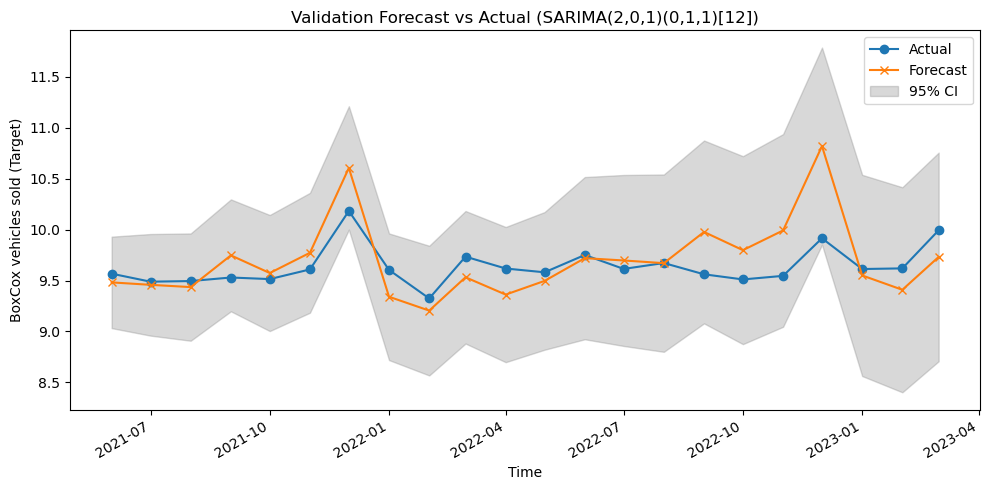

Validation Back-transformed MAPE: 0.2562
Validation Back-transformed RMSE: 8822.05


In [15]:

# Fit SARIMA(2,0,1)(0,1,1)[12] on train set
sarima_model = SARIMAX(
    train["BoxCox vehicles sold (Target)"],
    order=(2, 0, 1),
    seasonal_order=(0, 1, 1, 12),
    enforce_stationarity=False,
    enforce_invertibility=False
)
sarima_results = sarima_model.fit()
print(sarima_results.summary())

# Forecast for validation period
val_steps = len(val)
sarima_pred = sarima_results.get_forecast(steps=val_steps)
sarima_forecast = sarima_pred.predicted_mean
sarima_conf_int = sarima_pred.conf_int()

# Create time index for validation forecasts
val_index = df["Time Period (T)"].iloc[train_end:val_end]
# Plot actual vs predicted for validation set with date-formatted x-axis
fig, ax = plt.subplots(figsize=(10, 5))
val_dates = val_index
actuals_boxcox = df["BoxCox vehicles sold (Target)"].iloc[train_end:val_end]
ax.plot(val_dates, actuals_boxcox, label="Actual", marker='o')
ax.plot(val_dates, sarima_forecast, label="Forecast", marker='x')
ax.fill_between(val_dates, sarima_conf_int.iloc[:, 0], sarima_conf_int.iloc[:, 1], color='gray', alpha=0.3, label="95% CI")
ax.set_title("Validation Forecast vs Actual (SARIMA(2,0,1)(0,1,1)[12])")
ax.set_xlabel("Time")
ax.set_ylabel("BoxCox vehicles sold (Target)")
ax.legend()
ax.xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%Y-%m'))
fig.autofmt_xdate()
plt.tight_layout()
plt.show()

# Inverse Box-Cox transformation
def inv_boxcox(y, lam):
    if abs(lam) < 1e-6:
        return np.exp(y)
    else:
        return np.power(lam * y + 1, 1 / lam)

# Get actuals for the validation period
actuals_val = df["Total vehicles sold (Target)"].iloc[train_end:val_end].values
# Back-transform forecasts
forecast_back_val = inv_boxcox(sarima_forecast.values, fitted_lambda)

# Calculate metrics for validation
mape_val = mean_absolute_percentage_error(actuals_val, forecast_back_val)
rmse_val = np.sqrt(mean_squared_error(actuals_val, forecast_back_val))

print(f"Validation Back-transformed MAPE: {mape_val:.4f}")
print(f"Validation Back-transformed RMSE: {rmse_val:.2f}")



#### SARIMA Baseline Model: No Exogenous Features

**Model Spec:** SARIMA(2,0,1)(0,1,1)[12]  
**Target:** BoxCox-transformed EV Sales  
**Transform Lambda:** λ = [your fitted_lambda]

#####  In-sample Summary
- AIC: -5.784
- BIC: 9.169
- Log Likelihood: 7.892
- Coefficient Significance:
  - ar.L1: ✓
  - ar.L2: ✗ (p = 0.174)
  - ma.L1, ma.S.L12: ✓
- Ljung-Box (p = 0.95): Residuals ≈ white noise  
- Jarque-Bera: ✗ Non-normal residuals (p = 0.00)  
- Heteroskedasticity: No strong evidence (p = 0.95)

#####  Validation Performance
- RMSE (back-transformed): 8822.05
- MAPE (back-transformed): 0.2562%
- Forecast captures seasonal trends well  
- Slight under/overshooting during high-variance peaks

##### Notes
- Model provides a strong benchmark for comparison  
- Clean residual structure despite slight non-normality  
- Ready to test impact of exogenous regressors


                                     SARIMAX Results                                      
Dep. Variable:      BoxCox vehicles sold (Target)   No. Observations:                  217
Model:             SARIMAX(2, 0, 1)x(0, 1, 1, 12)   Log Likelihood                  17.105
Date:                            Sat, 12 Jul 2025   AIC                            -24.211
Time:                                    16:44:43   BIC                             -7.949
Sample:                                         0   HQIC                           -17.624
                                            - 217                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.2307      0.124      9.924      0.000       0.988       1.474
ar.L2         -0.2476      0.121   

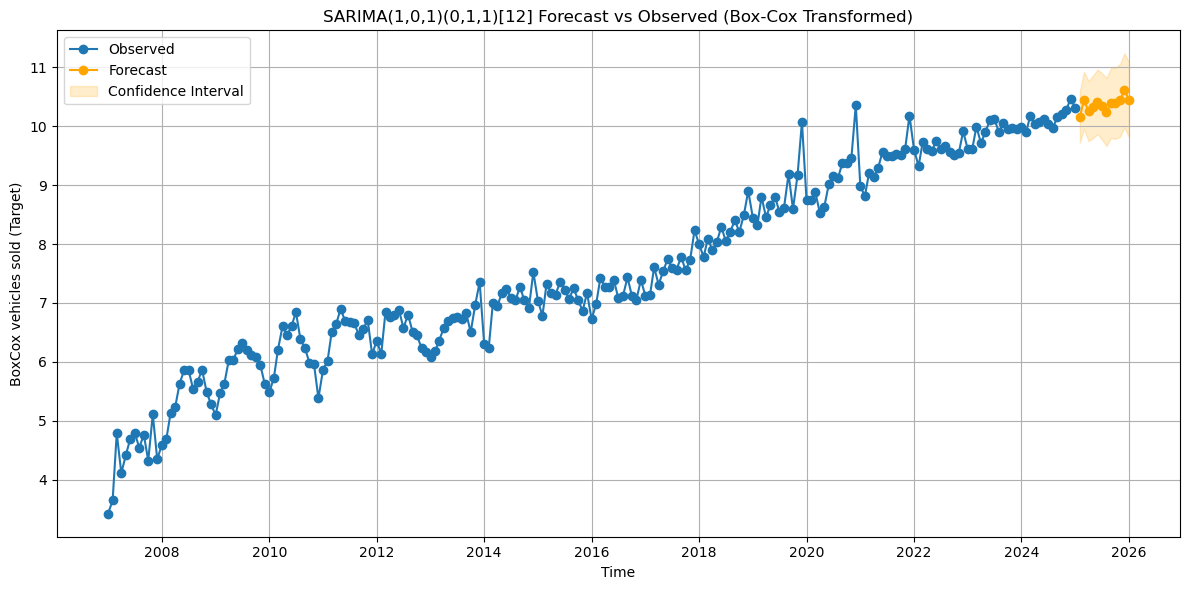

Back-transformed MAPE: 0.2636
Back-transformed RMSE: 7455.67


In [ ]:
# # Fit SARIMA(2,0,1)(0,1,1)[12] model on BoxCox-transformed target 
# sarima_model = SARIMAX(
#     df["BoxCox vehicles sold (Target)"],
#     order=(2, 0, 1), 
#     seasonal_order=(0, 1, 1, 12),
#     enforce_stationarity=False,
#     enforce_invertibility=False
# )
# sarima_results = sarima_model.fit()
# print(sarima_results.summary())

# # Forecast 12 steps ahead
# forecast_steps = 12
# sarima_pred = sarima_results.get_forecast(steps=forecast_steps)
# sarima_forecast = sarima_pred.predicted_mean
# sarima_conf_int = sarima_pred.conf_int()

# # Create time index for forecasts
# last_date = df["Time Period (T)"].iloc[-1]
# sarima_forecast_index = pd.date_range(last_date, periods=forecast_steps + 1, freq='MS')[1:]

# # Plot observed vs forecasted
# plt.figure(figsize=(12, 6))
# plt.plot(df["Time Period (T)"], df["BoxCox vehicles sold (Target)"], label="Observed", marker='o')
# plt.plot(sarima_forecast_index, sarima_forecast, label="Forecast", color="orange", marker='o')
# plt.fill_between(
#     sarima_forecast_index,
#     sarima_conf_int.iloc[:, 0],
#     sarima_conf_int.iloc[:, 1],
#     color="orange",
#     alpha=0.2,
#     label="Confidence Interval"
# )
# plt.title("SARIMA(1,0,1)(0,1,1)[12] Forecast vs Observed (Box-Cox Transformed)")
# plt.xlabel("Time")
# plt.ylabel("BoxCox vehicles sold (Target)")
# plt.legend()
# plt.grid(True)
# plt.tight_layout()
# plt.show()


# # Inverse Box-Cox transformation
# def inv_boxcox(y, lam):
#     if abs(lam) < 1e-6:
#         return np.exp(y)
#     else:
#         return np.power(lam * y + 1, 1 / lam)

# # Get actuals for the forecast period
# actuals = df["Total vehicles sold (Target)"].iloc[-forecast_steps:].values
# # Back-transform forecasts
# forecast_back = inv_boxcox(sarima_forecast.values, fitted_lambda)

# # Calculate metrics
# mape = mean_absolute_percentage_error(actuals, forecast_back)
# rmse = np.sqrt(mean_squared_error(actuals, forecast_back))

# print(f"Back-transformed MAPE: {mape:.4f}")
# print(f"Back-transformed RMSE: {rmse:.2f}")



## Adding Candidate predictors:
- Fiscal:
    'Company car tax rate (%)'
- google searchterms:
    Home charging (G)', 'Electric car (G)', 'Hybrid electric (G) 
- Consumer confidence:
    'Consumer confidence (E)', 'Economic climate perception (E)', 'Willingness to buy (E)'
Fuel prices:
- 'Diesel price (E)', Gasoline price (E)'


The goal/ workflow will be as followed:
1. Data Cleaning & Transformation --> Apply Box-Cox or log transform
2. Stationarity Check --> ADF + diferencing if needed
3. split data
4. Univariate SARIMAX + Lag Testing Fit SARIMAX using one predictor at a time: 
    Review:

    AIC, AICc, BIC

    Coefficient significance (results.pvalues)

    Residual autocorrelation (Ljung-Box)
    Try lagged exogenous variables to see delayed effets (e.g. search interestc may impact EV sales 1–3 months later).

repeat 1-4 until all candidate predictors are added then select stromngest preficitors 
Track metrics:

RMSE, MAE, MASE on test_df

Residual diagnostics

5. Forecast intervals
6.  Model Evaluation & Logging

## 'Company car tax rate (%)'

### 1. Data Cleaning & Transformation --> Apply Box-Cox or log transform

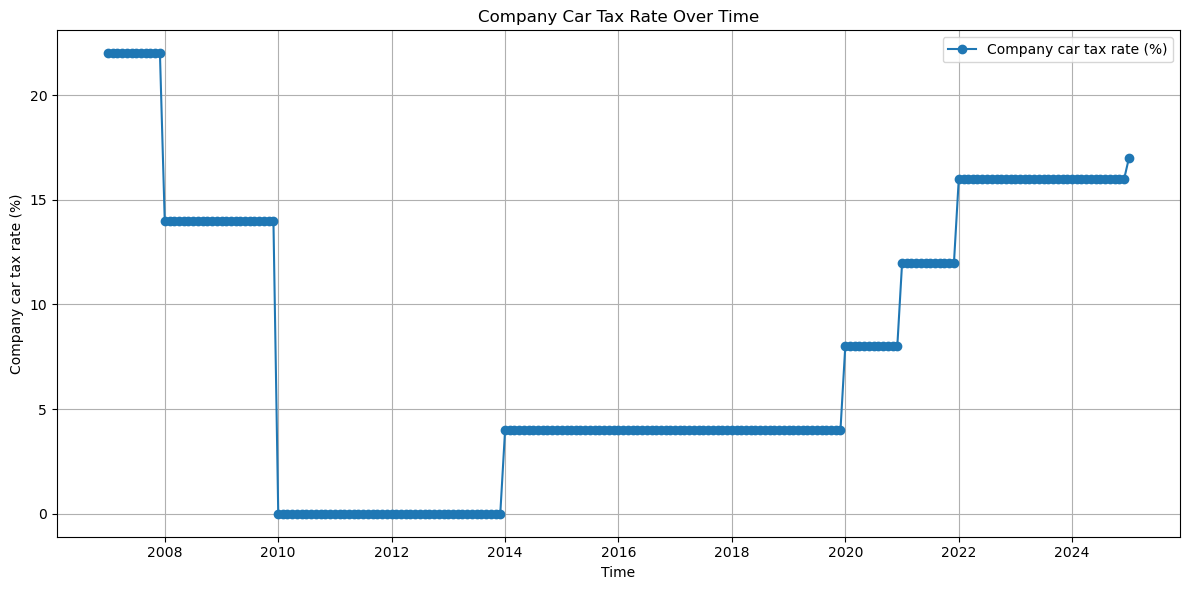

In [16]:
plt.figure(figsize=(12, 6))
plt.plot(df["Time Period (T)"], df["Company car tax rate (%)"], marker='o', label="Company car tax rate (%)")
plt.xlabel("Time")
plt.ylabel("Company car tax rate (%)")
plt.title("Company Car Tax Rate Over Time")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

I see hardly any varience in the data, so i will apply a box cox transformation to the data.

because some of thre values are 0, i will add a constant of 1 to the data before applying the box cox transformation.

Box-Cox lambda (after +1 shift): 0.3553


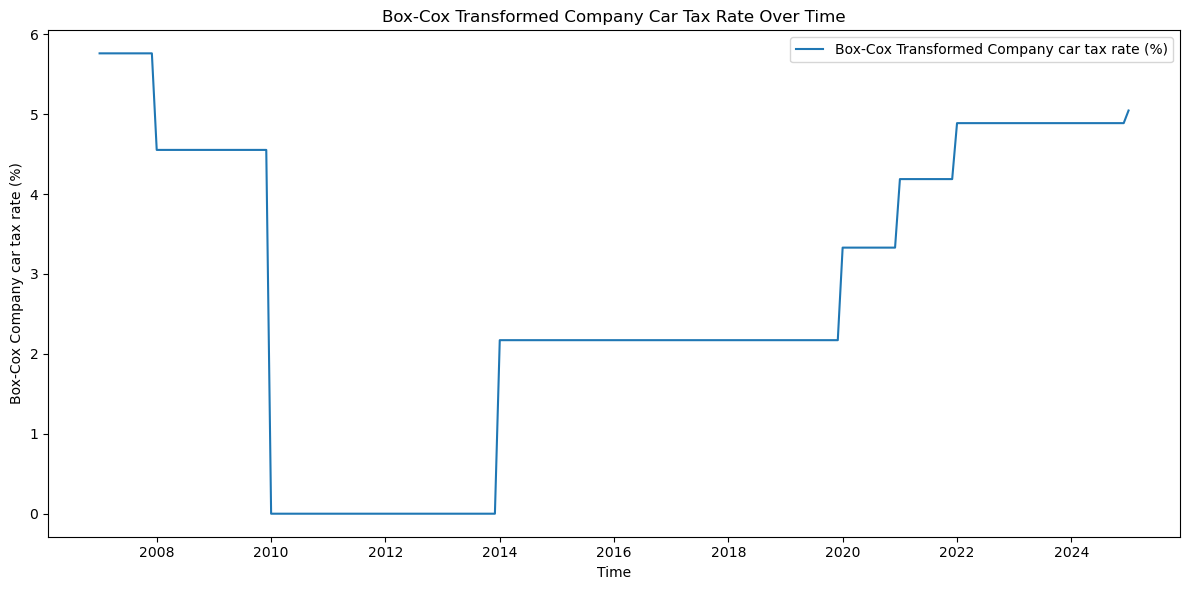

In [17]:
tax_col = "Company car tax rate (%)"
tax_values = df[tax_col].values

# Add a small shift to make all values strictly positive
tax_values_shifted = tax_values + 1

# Apply Box-Cox
tax_boxcox, tax_lambda = boxcox(tax_values_shifted)

# Save transformed values
df['BoxCox ' + tax_col] = tax_boxcox

print(f"Box-Cox lambda (after +1 shift): {tax_lambda:.4f}")

plt.figure(figsize=(12, 6))
plt.plot(df["Time Period (T)"], tax_boxcox, label="Box-Cox Transformed Company car tax rate (%)")
plt.xlabel("Time")
plt.ylabel("Box-Cox Company car tax rate (%)")
plt.title("Box-Cox Transformed Company Car Tax Rate Over Time")
plt.legend()
plt.tight_layout()
plt.show()


Doesnt seem like the box cox transformation did much, so i will continue with checking stationarity/Differencing the data

### 2. Stationarity Check

In [18]:
# Perform Augmented Dickey-Fuller test on Box-Cox transformed (not differenced) tax rate
adf_tax_boxcox = adfuller(tax_boxcox)

print("ADF Statistic (Box-Cox tax rate): {:.4f}".format(adf_tax_boxcox[0]))
print("p-value: {:.4f}".format(adf_tax_boxcox[1]))
for key, value in adf_tax_boxcox[4].items():
    print(f"Critical Value ({key}): {value:.4f}")

if adf_tax_boxcox[1] < 0.05:
    print("The series is likely stationary (reject H0).")
else:
    print("The series is likely non-stationary (fail to reject H0).")

ADF Statistic (Box-Cox tax rate): -1.6268
p-value: 0.4692
Critical Value (1%): -3.4610
Critical Value (5%): -2.8750
Critical Value (10%): -2.5740
The series is likely non-stationary (fail to reject H0).


Looking at the adf results we can see that the p-value is 0.4692, which is much higher than the 0.05 threshold, meaning we fail to reject the null hypothesis of a unit root, indicating that the series is non-stationary.
we will continue with applying a first difference to the data to remove the trend, and then re-evaluate stationarity using the ADF test again.

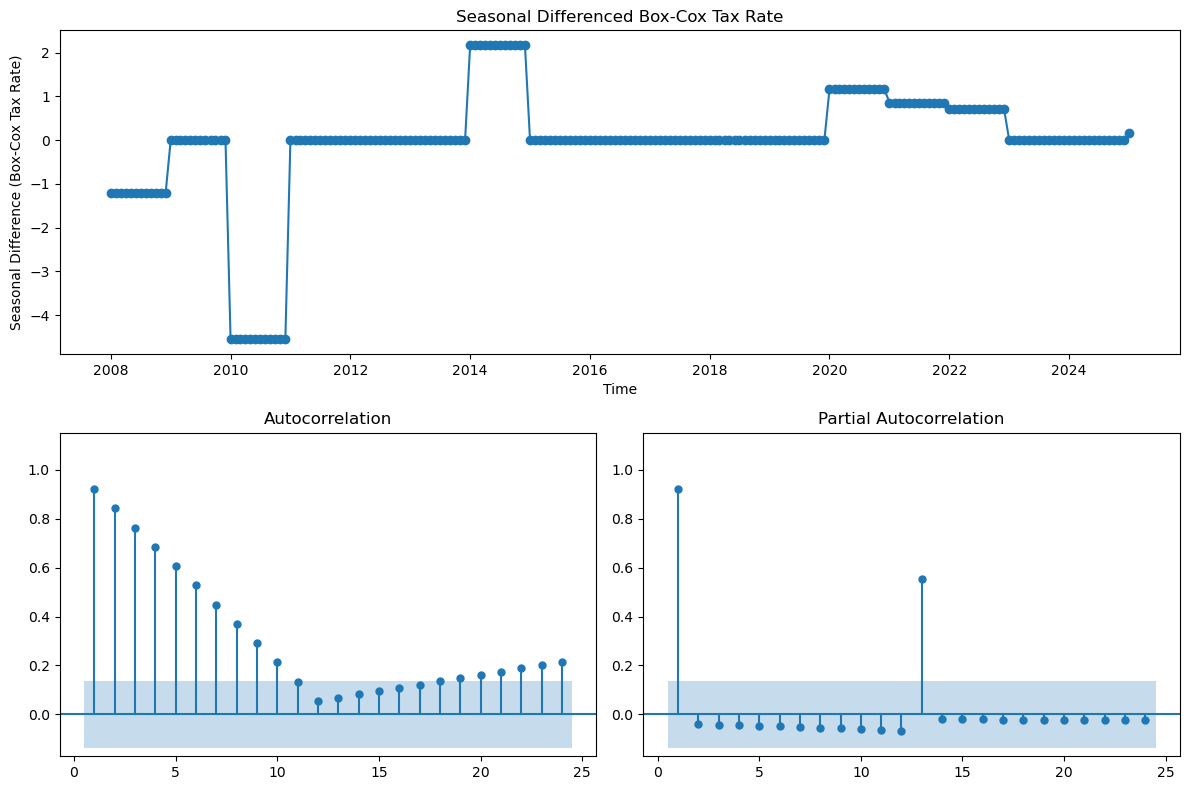

ADF Statistic (seasonal differenced): -1.9011
p-value: 0.3315
Critical Value (1%): -3.4649
Critical Value (5%): -2.8767
Critical Value (10%): -2.5749
The series is likely non-stationary (fail to reject H0).


In [19]:

# Convert tax_boxcox to Series to align with time index
tax_boxcox_series = pd.Series(tax_boxcox, index=df.index)

# Compute 12-lag seasonal difference
seasonal_diff = tax_boxcox_series.diff(12).dropna()

# Create plots
fig = plt.figure(figsize=(12, 8))
gs = fig.add_gridspec(2, 2)
ax1 = fig.add_subplot(gs[0, :])
ax2 = fig.add_subplot(gs[1, 0])
ax3 = fig.add_subplot(gs[1, 1])

# Time-series plot
ax1.plot(df["Time Period (T)"].iloc[12:], seasonal_diff, marker="o")
ax1.set_ylabel("Seasonal Difference (Box-Cox Tax Rate)")
ax1.set_xlabel("Time")
ax1.set_title("Seasonal Differenced Box-Cox Tax Rate")

# ACF and PACF
plot_acf(seasonal_diff, ax2, zero=False, lags=24, bartlett_confint=False, auto_ylims=True)
plot_pacf(seasonal_diff, ax3, zero=False, lags=24, auto_ylims=True)
plt.tight_layout()
plt.show()

# ADF Test
adf_result = adfuller(seasonal_diff)

print("ADF Statistic (seasonal differenced): {:.4f}".format(adf_result[0]))
print("p-value: {:.4f}".format(adf_result[1]))
for key, value in adf_result[4].items():
    print(f"Critical Value ({key}): {value:.4f}")

if adf_result[1] < 0.05:
    print("The series is likely stationary (reject H0).")
else:
    print("The series is likely non-stationary (fail to reject H0).")

after first order differencing the data, we can see that the p-value is still above the 0.05 threshold, i will apply a second order difference to the data to see if that helps with the stationarity of the data.

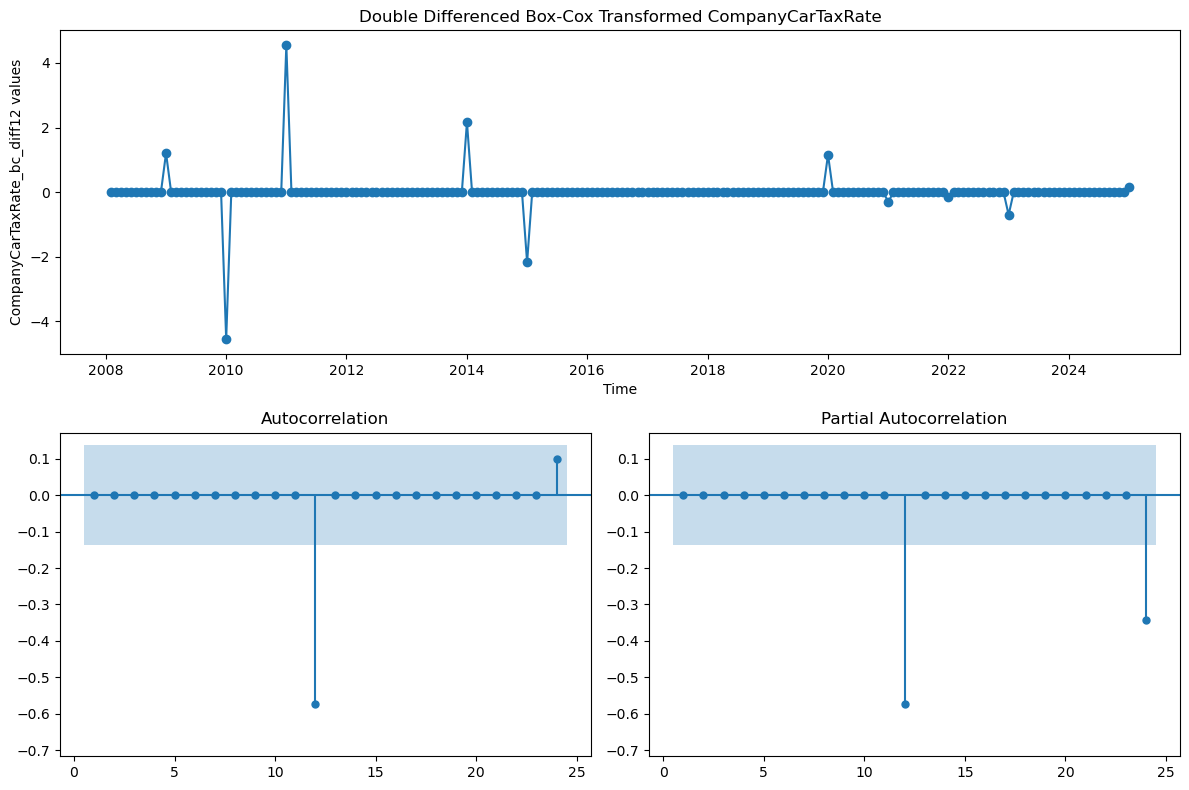

ADF Statistic (CompanyCarTaxRate_bc_diff12): -7.5682
p-value: 0.0000
Critical Value (1%): -3.4649
Critical Value (5%): -2.8767
Critical Value (10%): -2.5749
The series 'CompanyCarTaxRate_bc_diff12' is likely stationary (reject H0).


In [20]:


# Define a unique base name for the feature
feature_name = "CompanyCarTaxRate"
unique_prefix = f"{feature_name}_bc_diff12"

# Convert to Series (for easier indexing)
tax_boxcox_series = pd.Series(tax_boxcox, index=df.index)

# Step 1: First difference
df[f"{unique_prefix}_diff1"] = tax_boxcox_series.diff()

# Step 2: Seasonal difference after first difference
df[f"{unique_prefix}_diff1_seasonal"] = df[f"{unique_prefix}_diff1"].diff(12)

# Drop NaNs for stationarity tests and plots
stationary_series = df[f"{unique_prefix}_diff1_seasonal"].dropna()

# Plotting
fig = plt.figure(figsize=(12, 8))
gs = fig.add_gridspec(2, 2)
ax1 = fig.add_subplot(gs[0, :])
ax2 = fig.add_subplot(gs[1, 0])
ax3 = fig.add_subplot(gs[1, 1])

# Time plot
ax1.plot(df["Time Period (T)"].iloc[13:], stationary_series, marker="o")
ax1.set_ylabel(f"{unique_prefix} values")
ax1.set_xlabel("Time")
ax1.set_title(f"Double Differenced Box-Cox Transformed {feature_name}")

# ACF and PACF
plot_acf(stationary_series, ax2, zero=False, lags=24, bartlett_confint=False, auto_ylims=True)
plot_pacf(stationary_series, ax3, zero=False, lags=24, auto_ylims=True)
plt.tight_layout()
plt.show()

# ADF Test
adf_result = adfuller(stationary_series)

print(f"ADF Statistic ({unique_prefix}): {adf_result[0]:.4f}")
print(f"p-value: {adf_result[1]:.4f}")
for key, value in adf_result[4].items():
    print(f"Critical Value ({key}): {value:.4f}")

if adf_result[1] < 0.05:
    print(f"The series '{unique_prefix}' is likely stationary (reject H0).")
else:
    print(f"The series '{unique_prefix}' is likely non-stationary (fail to reject H0).")


Now the tax data looks stationary, DAF Statistic = -7.57 is well below all critical values (1%, 5%, 10% thresholds).
p value of 0 is also well below the 0.05 threshold, meaning we can reject the null hypothesis of a unit root, indicating that the series is stationary.


### 3. Split Data

lets do 80/10/10 split for train/validation/test sets

In [23]:
# Set the datetime index for the DataFrame (if not already set)
df = df.set_index("Time Period (T)")

# Drop NA from stationary_series and align its index to datetime
stationary_series = stationary_series.copy()
stationary_series.index = df.index[-len(stationary_series):]  # align to last N dates

# Calculate split indices for 80/10/10 split using datetime index
n = len(stationary_series)
train_end = int(n * 0.8)
val_end = int(n * 0.9)

# Get the datetime indices for splits
dates = stationary_series.index
train_idx = dates[:train_end]
val_idx = dates[train_end:val_end]
test_idx = dates[val_end:]

# Split the double differenced series (stationary_series) using datetime index
tax_train = stationary_series.loc[train_idx]
tax_val = stationary_series.loc[val_idx]
tax_test = stationary_series.loc[test_idx]

print(f"Train length: {len(tax_train)}")
print(f"Validation length: {len(tax_val)}")
print(f"Test length: {len(tax_test)}")

# Ensure the column exists in df, if not, create it
if 'CompanyCarTaxRate_bc_diff12_diff1_seasonal' not in df.columns:
    feature_name = "CompanyCarTaxRate"
    unique_prefix = f"{feature_name}_bc_diff12"
    tax_boxcox_series = pd.Series(tax_boxcox, index=df.index)
    df[f"{unique_prefix}_diff1"] = tax_boxcox_series.diff()
    df[f"{unique_prefix}_diff1_seasonal"] = df[f"{unique_prefix}_diff1"].diff(12)

# Add the cleaned predictor as exog, aligned by datetime index
exog_train = df['CompanyCarTaxRate_bc_diff12_diff1_seasonal'].loc[train_idx]

Train length: 163
Validation length: 20
Test length: 21


### 4. Fit SARIMA model on the training set

looking at pacf plot the max lag we should test is 25

In [26]:
# Settings
max_lag = 25  # How many lags you'd like to test

# Ensure df is indexed by datetime and has freq set
if not isinstance(df.index, pd.DatetimeIndex):
    df = df.set_index("Time Period (T)")
if df.index.freq is None:
    df = df.asfreq("MS")  # Set to monthly start, adjust if your data is not monthly

target_series = df["BoxCox vehicles sold (Target)"].loc[tax_train.index]

# Store results
lag_results = []

for lag in range(0, max_lag + 1):
    # Create lagged exogenous variable
    if lag == 0:
        exog = tax_train.copy()
        label = "lag0"
        model_target = target_series
    else:
        exog = tax_train.shift(lag).dropna()
        model_target = target_series.loc[exog.index]
        label = f"lag{lag}"

    # Ensure both have DatetimeIndex and freq set
    exog.index = pd.DatetimeIndex(exog.index)
    model_target.index = pd.DatetimeIndex(model_target.index)
    if exog.index.freq is None:
        exog.index = exog.index.to_period("M").to_timestamp()  # Set freq to monthly
    if model_target.index.freq is None:
        model_target.index = model_target.index.to_period("M").to_timestamp()

    # Fit SARIMAX
    model = SARIMAX(
        model_target,
        exog=exog,
        order=(2, 0, 1),
        seasonal_order=(0, 1, 1, 12),
        enforce_stationarity=False,
        enforce_invertibility=False
    )

    results = model.fit(disp=False)

    # Log metrics
    lag_results.append({
        "Lag": label,
        "AIC": results.aic,
        "BIC": results.bic,
        "Coefficient p-value": results.pvalues.get(label, None),
        "Log Likelihood": results.llf
    })

# Compare results in a DataFrame
lag_df = pd.DataFrame(lag_results).sort_values("AIC")
print("\n📊 Lag Comparison Summary:")
print(lag_df)


📊 Lag Comparison Summary:
      Lag       AIC        BIC Coefficient p-value  Log Likelihood
12  lag12 -4.396289  12.573593                None        8.198145
10  lag10 -3.638088  13.427035                None        7.819044
13  lag13 -3.428953  13.492737                None        7.714476
14  lag14 -2.750277  14.122829                None        7.375139
11  lag11 -1.578018  15.439674                None        6.789009
25  lag25 -1.413444  14.897549                None        6.706722
20  lag20 -1.381358  15.191686                None        6.690679
0    lag0 -1.143388  16.376497                None        6.571694
19  lag19 -0.967889  15.656218                None        6.483945
15  lag15 -0.954791  15.869335                None        6.477396
16  lag16 -0.874967  15.899776                None        6.437484
9    lag9 -0.844489  16.267692                None        6.422245
17  lag17 -0.758532  15.966418                None        6.379266
21  lag21 -0.704332  15.817209     

lag 12 came best out of the box, so i will use that as a seasonal lag

In [27]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Use the 12-month lagged exogenous variable
exog_lag12 = tax_train.shift(12).dropna()
target_lag12 = df.loc[exog_lag12.index, "BoxCox vehicles sold (Target)"]

model = SARIMAX(
    target_lag12,
    exog=exog_lag12,
    order=(2, 0, 1),
    seasonal_order=(0, 1, 1, 12),
    enforce_stationarity=False,
    enforce_invertibility=False,
)

results = model.fit()
print(results.summary())


c:\Users\dylan\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\dylan\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


                                     SARIMAX Results                                      
Dep. Variable:      BoxCox vehicles sold (Target)   No. Observations:                  151
Model:             SARIMAX(2, 0, 1)x(0, 1, 1, 12)   Log Likelihood                   8.198
Date:                            Sat, 12 Jul 2025   AIC                             -4.396
Time:                                    16:54:10   BIC                             12.574
Sample:                                02-01-2009   HQIC                             2.498
                                     - 08-01-2021                                         
Covariance Type:                              opg                                         
                                                 coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------------
CompanyCarTaxRate_bc_diff12_diff1_seasonal     0.0

### 5. evaluate model

c:\Users\dylan\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\dylan\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


                                     SARIMAX Results                                      
Dep. Variable:      BoxCox vehicles sold (Target)   No. Observations:                  151
Model:             SARIMAX(2, 0, 1)x(0, 1, 1, 12)   Log Likelihood                   8.198
Date:                            Sat, 12 Jul 2025   AIC                             -4.396
Time:                                    16:55:51   BIC                             12.574
Sample:                                02-01-2009   HQIC                             2.498
                                     - 08-01-2021                                         
Covariance Type:                              opg                                         
                                                     coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------------
CompanyCarTaxRate_bc_diff12_diff1_seasonal

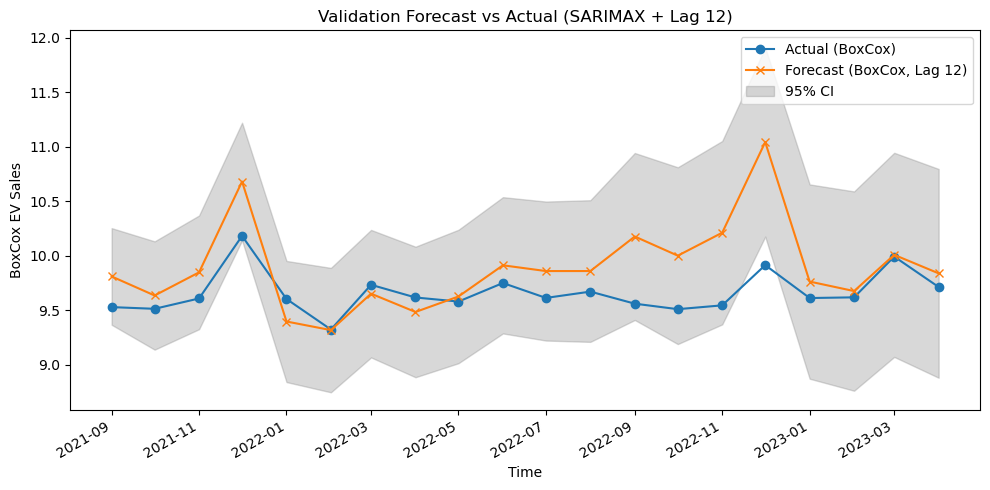

In [29]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from statsmodels.tsa.statespace.sarimax import SARIMAX

# 1️⃣ Prepare lagged exogenous predictor for train/val split
df['CompanyCarTaxRate_bc_diff12_diff1_seasonal_L12'] = df['CompanyCarTaxRate_bc_diff12_diff1_seasonal'].shift(12)

tax_lag12_train = df['CompanyCarTaxRate_bc_diff12_diff1_seasonal_L12'].loc[tax_train.index]
tax_lag12_val = df['CompanyCarTaxRate_bc_diff12_diff1_seasonal_L12'].loc[tax_val.index]

target_train = df['BoxCox vehicles sold (Target)'].loc[tax_train.index]
target_val = df['BoxCox vehicles sold (Target)'].loc[tax_val.index]

# Drop rows with NaN in exog for training
train_mask = ~tax_lag12_train.isna()
tax_lag12_train_clean = tax_lag12_train[train_mask]
target_train_clean = target_train[train_mask]

# 2️⃣ Fit SARIMAX model
model = SARIMAX(
    target_train_clean,
    exog=tax_lag12_train_clean,
    order=(2, 0, 1),
    seasonal_order=(0, 1, 1, 12),
    enforce_stationarity=False,
    enforce_invertibility=False
)

results = model.fit()
print(results.summary())

# Align validation exog and target (drop NaNs in exog)
val_mask = ~tax_lag12_val.isna()
tax_lag12_val_clean = tax_lag12_val[val_mask]
target_val_clean = target_val[val_mask]

# 3️⃣ Forecast validation set
forecast = results.get_forecast(steps=len(tax_lag12_val_clean), exog=tax_lag12_val_clean)
preds = forecast.predicted_mean
conf_int = forecast.conf_int()

# 4️⃣ Evaluate performance
rmse = np.sqrt(mean_squared_error(target_val_clean, preds))
mape = mean_absolute_percentage_error(target_val_clean, preds) * 100

print(f"\n📊 Forecast Evaluation (Validation Set):")
print(f"RMSE (BoxCox): {rmse:.4f}")
print(f"MAPE (BoxCox): {mape:.2f}%")

# Back-transform predictions and actuals to original scale
def inv_boxcox(y, lam):
    if abs(lam) < 1e-6:
        return np.exp(y)
    else:
        return np.power(lam * y + 1, 1 / lam)

# Use the same lambda as used for Box-Cox on the target
preds_back = inv_boxcox(preds.values, fitted_lambda)
actuals_back = inv_boxcox(target_val_clean.values, fitted_lambda)

rmse_back = np.sqrt(mean_squared_error(actuals_back, preds_back))
mape_back = mean_absolute_percentage_error(actuals_back, preds_back) * 100

print(f"RMSE (Back-transformed): {rmse_back:.2f}")
print(f"MAPE (Back-transformed): {mape_back:.2f}%")
# ...existing code...
# 5️⃣ Plot actual vs predicted with date-formatted x-axis
fig, ax = plt.subplots(figsize=(10, 5))
val_dates = target_val_clean.index  # Use index if it's datetime
ax.plot(val_dates, target_val_clean, label="Actual (BoxCox)", marker='o')
ax.plot(val_dates, preds, label="Forecast (BoxCox, Lag 12)", marker='x')
ax.fill_between(val_dates, conf_int.iloc[:, 0], conf_int.iloc[:, 1], color='gray', alpha=0.3, label="95% CI")
ax.set_title("Validation Forecast vs Actual (SARIMAX + Lag 12)")
ax.set_xlabel("Time")
ax.set_ylabel("BoxCox EV Sales")
ax.legend()
ax.xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%Y-%m'))
fig.autofmt_xdate()
plt.tight_layout()
plt.show()
# ...existing code...


##### SARIMAX Model with Lagged Tax Rate (L12)

**Model Specification:**  
- SARIMAX(2,0,1)(0,1,1)[12]  
- Exogenous Regressor: `CompanyCarTaxRate_bc_diff12_diff1_seasonal` (Lag 12)  
- Target Variable: BoxCox-transformed EV Sales  
- BoxCox Lambda: λ = *[your fitted lambda]*

---

#####  In-sample Summary
- **AIC:** -4.396  
- **BIC:** 12.574  
- **Log Likelihood:** 8.198  
- **Coefficient Significance:**
  - `CompanyCarTaxRate_L12`: borderline (p = 0.053)
  - `ar.L1`: significant (p < 0.001)
  - `ar.L2`: significant (p = 0.035)
  - `ma.L1`, `ma.S.L12`: significant  
- **Ljung-Box Test (p = 0.94):** residuals resemble white noise  
- **Jarque-Bera Test (p = 0.00):** ✗ residuals not normally distributed  
- **Heteroskedasticity Test (p = 0.16):** no strong evidence of heteroskedasticity  

---

######  Validation Performance
- **RMSE (BoxCox):** 0.3857  
- **MAPE (BoxCox):** 2.82%  
- **RMSE (Back-transformed):** 13,033.54  
- **MAPE (Back-transformed):** 37.96%  
- Forecast captures seasonal structure but underperforms compared to baseline  
- Errors increase during high-variance periods

---

######  Notes
- Adding the lagged tax rate introduces a weak signal  
- Slightly better fit in-sample (higher Log Likelihood)  
- Out-of-sample performance worsens, indicating **possible overfitting**  



# Google  Home charging (G)'

 Home charging (G)', 'Electric car (G)', 'Hybrid electric (G) 

 1. Data Cleaning & Transformation --> Apply Box-Cox or log transform
2. Stationarity Check --> ADF + diferencing if needed
3. split data
4. Univariate SARIMAX + Lag Testing Fit SARIMAX using one predictor at a time: 
    Review:

###  1. Data Cleaning & Transformation Hybrid electric (G)


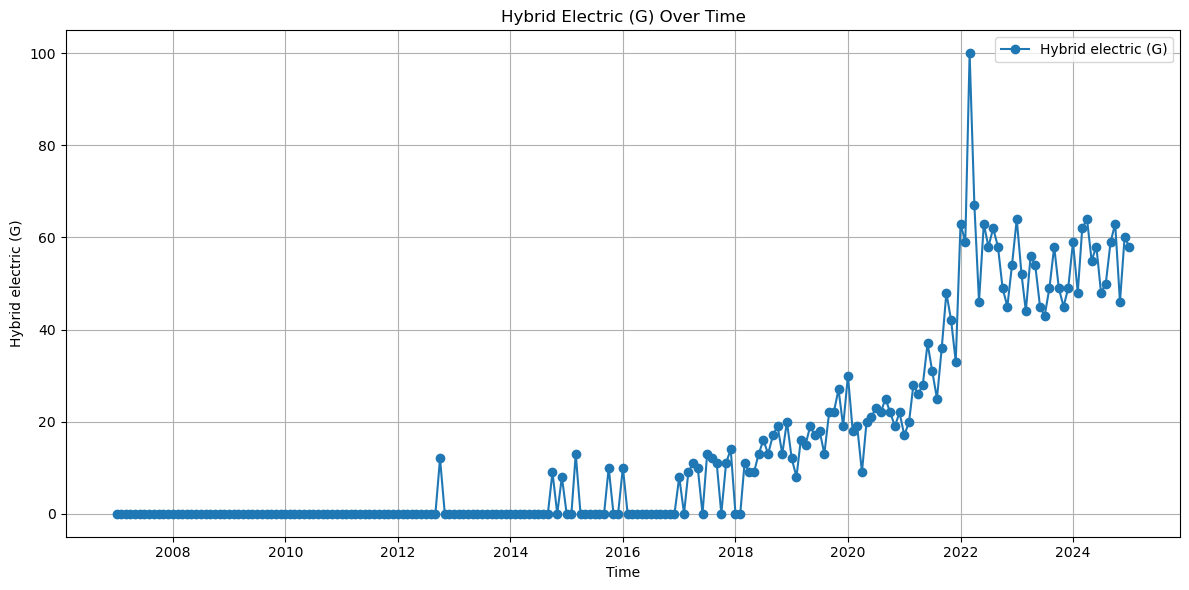

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(df.index, df["Hybrid electric (G)"], marker='o', label="Hybrid electric (G)")
plt.xlabel("Time")
plt.ylabel("Hybrid electric (G)")
plt.title("Hybrid Electric (G) Over Time")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Box-Cox lambda for 'Hybrid electric (G)': -0.2584


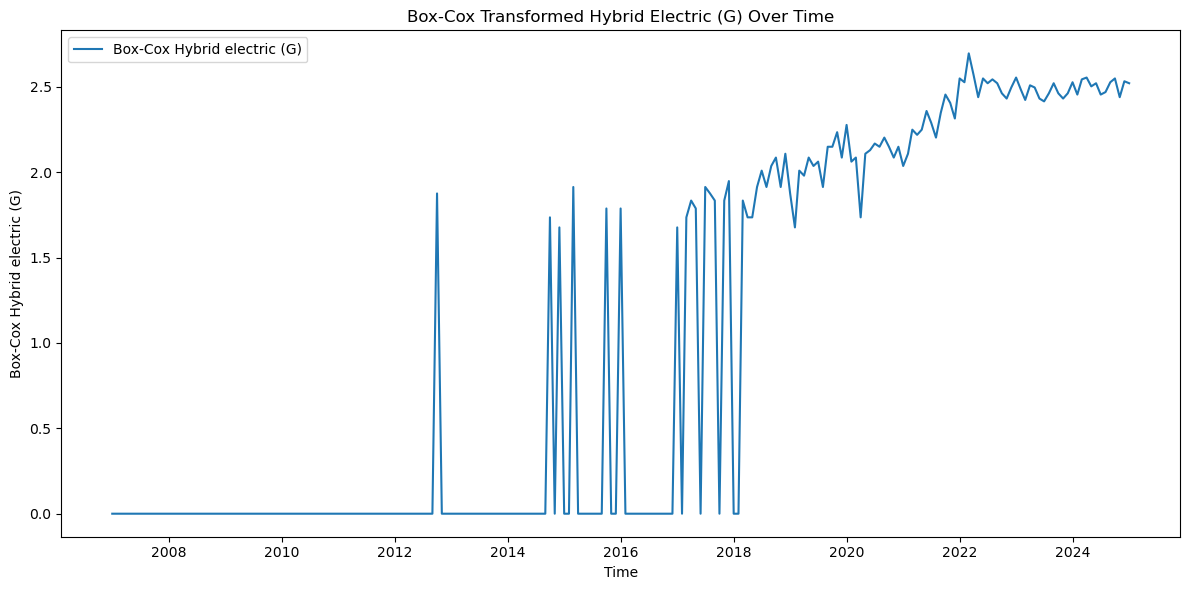

In [50]:
# Box-Cox transform for 'Hybrid electric (G)'
hybrid_col = "Hybrid electric (G)"
hybrid_values = df[hybrid_col].values

# Box-Cox requires strictly positive values, so add a small constant if needed
if (hybrid_values <= 0).any():
    hybrid_values_shifted = hybrid_values + 1
else:
    hybrid_values_shifted = hybrid_values

hybrid_boxcox, hybrid_lambda = boxcox(hybrid_values_shifted)

# Save transformed values to the DataFrame
df['BoxCox ' + hybrid_col] = hybrid_boxcox

print(f"Box-Cox lambda for '{hybrid_col}': {hybrid_lambda:.4f}")

plt.figure(figsize=(12, 6))
plt.plot(df.index, hybrid_boxcox, label="Box-Cox Hybrid electric (G)")
plt.xlabel("Time")
plt.ylabel("Box-Cox Hybrid electric (G)")
plt.title("Box-Cox Transformed Hybrid Electric (G) Over Time")
plt.legend()
plt.tight_layout()
plt.show()

### 2. Stationarity Check

nPerform Augmented Dickey-Fuller test on Box-Cox trasformed x

In [ ]:
# Perform Augmented Dickey-Fuller test on Box-Cox transformed Hybrid electric (G)
adf_hybrid = adfuller(df['BoxCox Hybrid electric (G)'])

print("ADF Statistic (Box-Cox Hybrid electric): {:.4f}".format(adf_hybrid[0]))
print("p-value: {:.4f}".format(adf_hybrid[1]))
for key, value in adf_hybrid[4].items():
    print(f"Critical Value ({key}): {value:.4f}")

if adf_hybrid[1] < 0.05:
    print("The series is likely stationary (reject H0).")
else:
    print("The series is likely non-stationary (fail to reject H0).")

ADF Statistic (Box-Cox Hybrid electric): -0.1078
p-value: 0.9487
Critical Value (1%): -3.4627
Critical Value (5%): -2.8757
Critical Value (10%): -2.5743
The series is likely non-stationary (fail to reject H0).


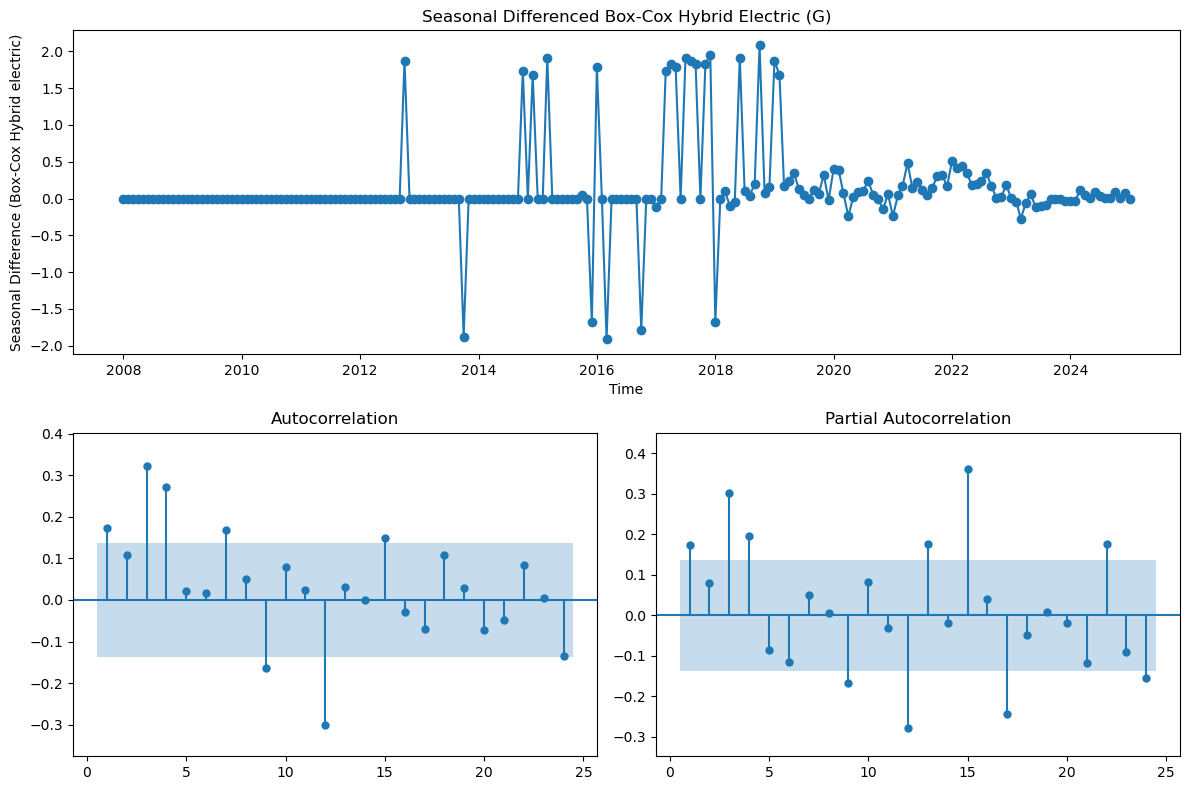

ADF Statistic (seasonal differenced): -2.4116
p-value: 0.1385
Critical Value (1%): -3.4652
Critical Value (5%): -2.8769
Critical Value (10%): -2.5749
The series is likely non-stationary (fail to reject H0).


In [55]:
# Convert BoxCox Hybrid electric (G) to Series to align with time index
hybrid_boxcox_series = pd.Series(df['BoxCox Hybrid electric (G)'].values, index=df.index)

# Compute 12-lag seasonal difference
seasonal_diff_hybrid = hybrid_boxcox_series.diff(12).dropna()

# Create plots
fig = plt.figure(figsize=(12, 8))
gs = fig.add_gridspec(2, 2)
ax1 = fig.add_subplot(gs[0, :])
ax2 = fig.add_subplot(gs[1, 0])
ax3 = fig.add_subplot(gs[1, 1])

# Time-series plot
ax1.plot(df.index[12:], seasonal_diff_hybrid, marker="o")
ax1.set_ylabel("Seasonal Difference (Box-Cox Hybrid electric)")
ax1.set_xlabel("Time")
ax1.set_title("Seasonal Differenced Box-Cox Hybrid Electric (G)")

# ACF and PACF
plot_acf(seasonal_diff_hybrid, ax2, zero=False, lags=24, bartlett_confint=False, auto_ylims=True)
plot_pacf(seasonal_diff_hybrid, ax3, zero=False, lags=24, auto_ylims=True)
plt.tight_layout()
plt.show()

# ADF Test
adf_result_hybrid = adfuller(seasonal_diff_hybrid)

print("ADF Statistic (seasonal differenced): {:.4f}".format(adf_result_hybrid[0]))
print("p-value: {:.4f}".format(adf_result_hybrid[1]))
for key, value in adf_result_hybrid[4].items():
    print(f"Critical Value ({key}): {value:.4f}")

if adf_result_hybrid[1] < 0.05:
    print("The series is likely stationary (reject H0).")
else:
    print("The series is likely non-stationary (fail to reject H0).")

since not stationary will perform second ord

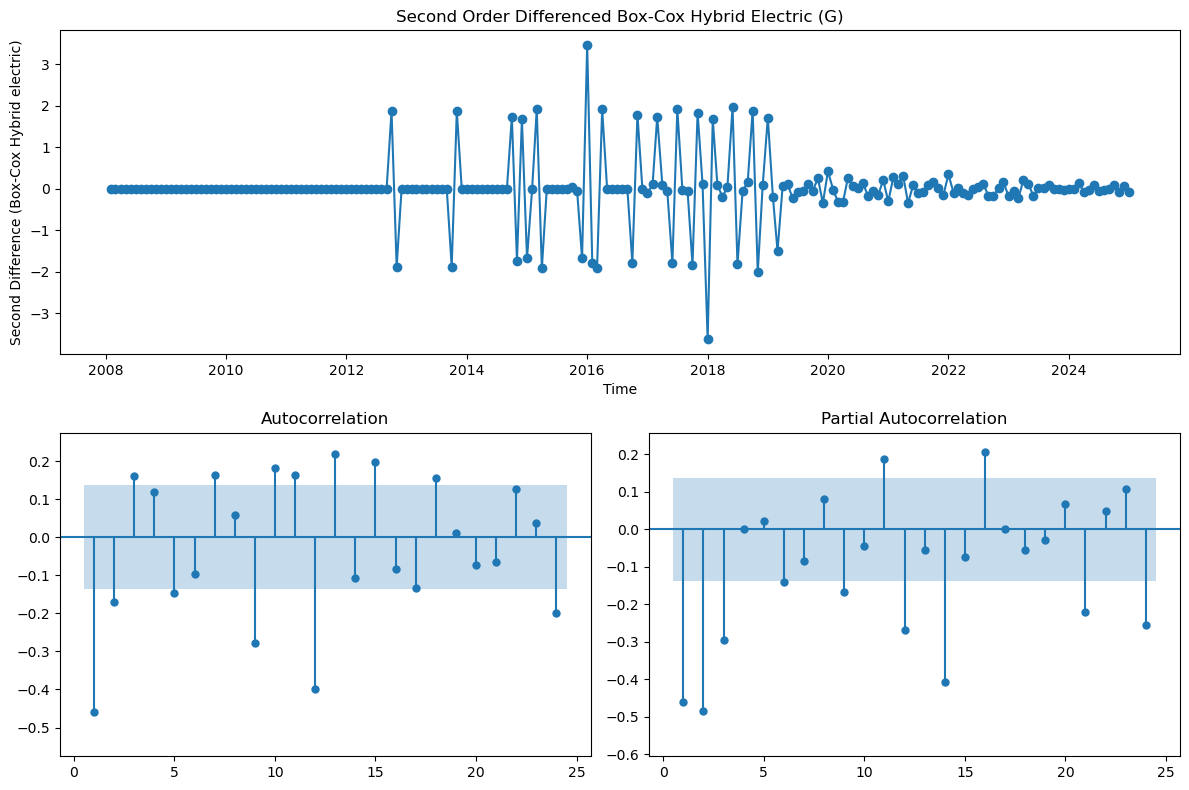

ADF Statistic (second difference): -5.0767
p-value: 0.0000
Critical Value (1%): -3.4656
Critical Value (5%): -2.8770
Critical Value (10%): -2.5750
The series is likely stationary (reject H0).


In [57]:
# Second order differencing on seasonal_diff_hybrid
second_diff_hybrid = seasonal_diff_hybrid.diff().dropna()

# Plot the second order differenced series
fig = plt.figure(figsize=(12, 8))
gs = fig.add_gridspec(2, 2)
ax1 = fig.add_subplot(gs[0, :])
ax2 = fig.add_subplot(gs[1, 0])
ax3 = fig.add_subplot(gs[1, 1])

# Time-series plot
ax1.plot(second_diff_hybrid.index, second_diff_hybrid, marker="o")
ax1.set_ylabel("Second Difference (Box-Cox Hybrid electric)")
ax1.set_xlabel("Time")
ax1.set_title("Second Order Differenced Box-Cox Hybrid Electric (G)")

# ACF and PACF
plot_acf(second_diff_hybrid, ax2, zero=False, lags=24, bartlett_confint=False, auto_ylims=True)
plot_pacf(second_diff_hybrid, ax3, zero=False, lags=24, auto_ylims=True)
plt.tight_layout()
plt.show()

# ADF Test
adf_result_hybrid_2nd = adfuller(second_diff_hybrid)

print("ADF Statistic (second difference): {:.4f}".format(adf_result_hybrid_2nd[0]))
print("p-value: {:.4f}".format(adf_result_hybrid_2nd[1]))
for key, value in adf_result_hybrid_2nd[4].items():
    print(f"Critical Value ({key}): {value:.4f}")

if adf_result_hybrid_2nd[1] < 0.05:
    print("The series is likely stationary (reject H0).")
else:
    print("The series is likely non-stationary (fail to reject H0).")


Signal from Chart	Interpretation	Action
No PACF spike at Lag 1–3	Weak self-dependence → no clear delayed behavior	Try lag 0 first (instantaneous effect)
Flat beyond Lag 3	Higher lags likely uninformative	No need to push lag testing beyond ~3
No seasonal spikes	No strong seasonality inside this predictor	Skip seasonal lags (e.g., 12, 24)

### 3. split data

In [58]:
# Align index if needed (should already be DatetimeIndex)
second_diff_hybrid = second_diff_hybrid.copy()
second_diff_hybrid.index = df.index[-len(second_diff_hybrid):]

# Calculate split indices
n = len(second_diff_hybrid)
train_end = int(n * 0.8)
val_end = int(n * 0.9)

dates = second_diff_hybrid.index
train_idx = dates[:train_end]
val_idx = dates[train_end:val_end]
test_idx = dates[val_end:]

# Split the series
hybrid2_train = second_diff_hybrid.loc[train_idx]
hybrid2_val = second_diff_hybrid.loc[val_idx]
hybrid2_test = second_diff_hybrid.loc[test_idx]

print(f"Train length: {len(hybrid2_train)}")
print(f"Validation length: {len(hybrid2_val)}")
print(f"Test length: {len(hybrid2_test)}")

Train length: 163
Validation length: 20
Test length: 21


### 4. Univariate SARIMAX + Lag Testing Fit SARIMAX using one predictor at a time:

In [59]:
# Settings
max_lag = 3  # How many lags you'd like to test

# Ensure df is indexed by datetime and has freq set
if not isinstance(df.index, pd.DatetimeIndex):
    df = df.set_index("Time Period (T)")
if df.index.freq is None:
    df = df.asfreq("MS")  # Set to monthly start, adjust if your data is not monthly

target_series = df["BoxCox vehicles sold (Target)"].loc[hybrid2_train.index]

# Store results
lag_results = []

for lag in range(0, max_lag + 1):
    # Create lagged exogenous variable
    if lag == 0:
        exog = hybrid2_train.copy()
        label = "lag0"
        model_target = target_series
    else:
        exog = hybrid2_train.shift(lag).dropna()
        model_target = target_series.loc[exog.index]
        label = f"lag{lag}"

    # Ensure both have DatetimeIndex and freq set
    exog.index = pd.DatetimeIndex(exog.index)
    model_target.index = pd.DatetimeIndex(model_target.index)
    if exog.index.freq is None:
        exog.index = exog.index.to_period("M").to_timestamp()
    if model_target.index.freq is None:
        model_target.index = model_target.index.to_period("M").to_timestamp()

    # Fit SARIMAX
    model = SARIMAX(
        model_target,
        exog=exog,
        order=(2, 0, 1),
        seasonal_order=(0, 1, 1, 12),
        enforce_stationarity=False,
        enforce_invertibility=False
    )

    results = model.fit(disp=False)

    # Log metrics
    lag_results.append({
        "Lag": label,
        "AIC": results.aic,
        "BIC": results.bic,
        "Coefficient p-value": results.pvalues.get(label, None),
        "Log Likelihood": results.llf
    })

# Compare results in a DataFrame
lag_df = pd.DataFrame(lag_results).sort_values("AIC")
print("\n📊 Lag Comparison Summary:")
print(lag_df)


📊 Lag Comparison Summary:
    Lag       AIC        BIC Coefficient p-value  Log Likelihood
0  lag0 -1.298079  16.221806                None        6.649040
2  lag2 -0.924334  16.507314                None        6.462167
1  lag1 -0.808473  16.667456                None        6.404237
3  lag3  1.110565  18.497604                None        5.444717


lag 0 is best 

                                     SARIMAX Results                                      
Dep. Variable:      BoxCox vehicles sold (Target)   No. Observations:                  163
Model:             SARIMAX(2, 0, 1)x(0, 1, 1, 12)   Log Likelihood                   6.649
Date:                            Mon, 14 Jul 2025   AIC                             -1.298
Time:                                    13:36:57   BIC                             16.222
Sample:                                02-01-2008   HQIC                             5.822
                                     - 08-01-2021                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
0              0.0049      0.012      0.413      0.680      -0.019       0.028
ar.L1          1.2865      0.151   

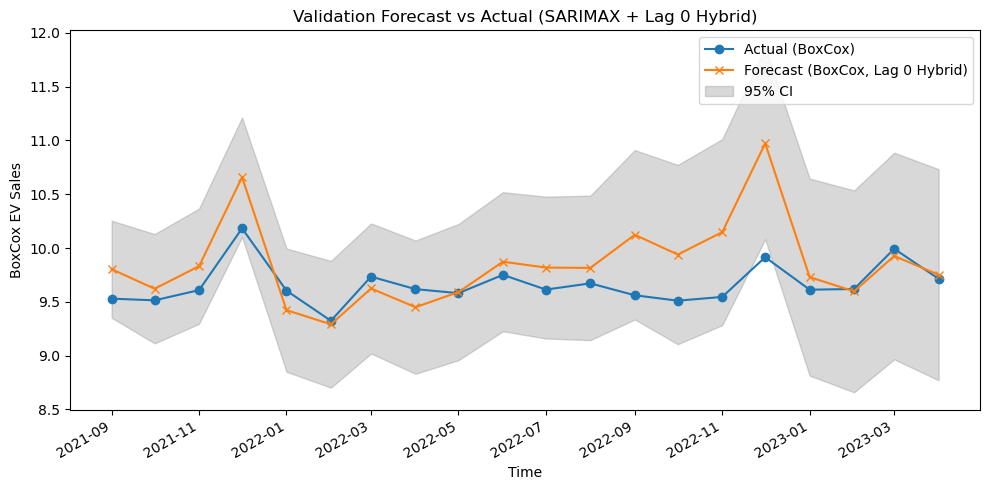

In [60]:
# Prepare exogenous predictor for train/val split (Hybrid electric, lag 0)
hybrid_lag0_train = hybrid2_train  # lag 0, so no shift
hybrid_lag0_val = hybrid2_val     # lag 0, so no shift

# Align with target and drop NaNs for training
train_mask = ~hybrid_lag0_train.isna()
hybrid_lag0_train_clean = hybrid_lag0_train[train_mask]
target_train_clean = target_train[train_mask]

# Fit SARIMAX model
model = SARIMAX(
    target_train_clean,
    exog=hybrid_lag0_train_clean,
    order=(2, 0, 1),
    seasonal_order=(0, 1, 1, 12),
    enforce_stationarity=False,
    enforce_invertibility=False
)
results = model.fit()
print(results.summary())

# Align validation exog and target (drop NaNs in exog)
val_mask = ~hybrid_lag0_val.isna()
hybrid_lag0_val_clean = hybrid_lag0_val[val_mask]
target_val_clean = target_val[val_mask]

# Forecast validation set
forecast = results.get_forecast(steps=len(hybrid_lag0_val_clean), exog=hybrid_lag0_val_clean)
preds = forecast.predicted_mean
conf_int = forecast.conf_int()

# Evaluate performance
rmse = np.sqrt(mean_squared_error(target_val_clean, preds))
mape = mean_absolute_percentage_error(target_val_clean, preds) * 100

print(f"\n📊 Forecast Evaluation (Validation Set):")
print(f"RMSE (BoxCox): {rmse:.4f}")
print(f"MAPE (BoxCox): {mape:.2f}%")

# Back-transform predictions and actuals to original scale
def inv_boxcox(y, lam):
    if abs(lam) < 1e-6:
        return np.exp(y)
    else:
        return np.power(lam * y + 1, 1 / lam)

preds_back = inv_boxcox(preds.values, fitted_lambda)
actuals_back = inv_boxcox(target_val_clean.values, fitted_lambda)

rmse_back = np.sqrt(mean_squared_error(actuals_back, preds_back))
mape_back = mean_absolute_percentage_error(actuals_back, preds_back) * 100

print(f"RMSE (Back-transformed): {rmse_back:.2f}")
print(f"MAPE (Back-transformed): {mape_back:.2f}%")

# Plot actual vs predicted
fig, ax = plt.subplots(figsize=(10, 5))
val_dates = target_val_clean.index
ax.plot(val_dates, target_val_clean, label="Actual (BoxCox)", marker='o')
ax.plot(val_dates, preds, label="Forecast (BoxCox, Lag 0 Hybrid)", marker='x')
ax.fill_between(val_dates, conf_int.iloc[:, 0], conf_int.iloc[:, 1], color='gray', alpha=0.3, label="95% CI")
ax.set_title("Validation Forecast vs Actual (SARIMAX + Lag 0 Hybrid)")
ax.set_xlabel("Time")
ax.set_ylabel("BoxCox EV Sales")
ax.legend()
ax.xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%Y-%m'))
fig.autofmt_xdate()
plt.tight_layout()
plt.show()

###  1. Data Cleaning & Transformation  Electric car (G)
plot x
perform boxcox on x

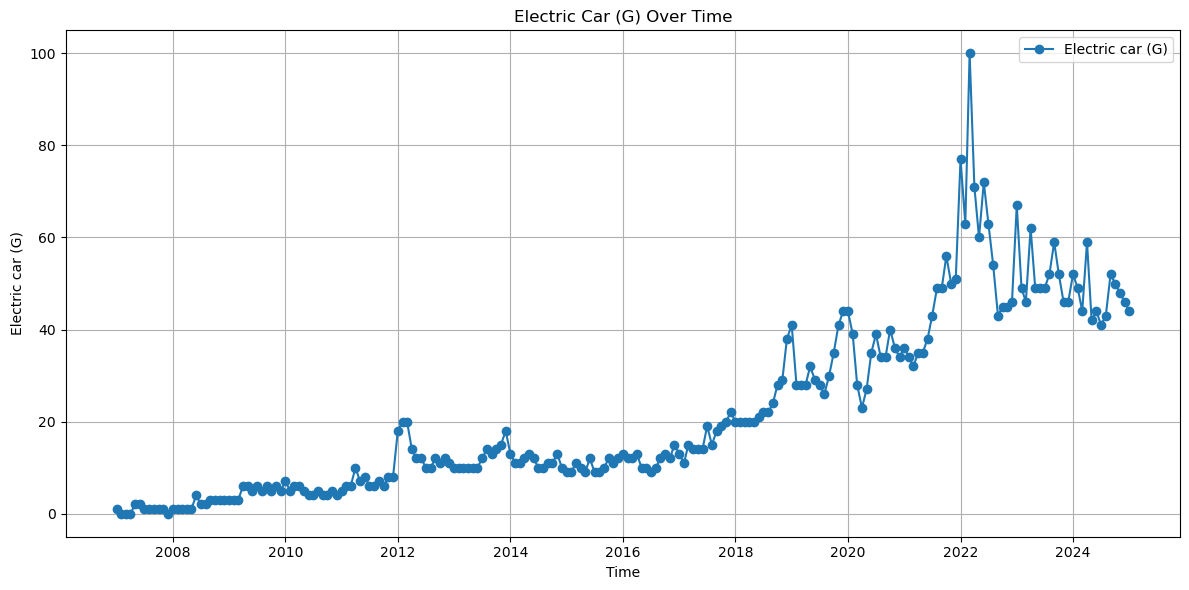

In [40]:
plt.figure(figsize=(12, 6))
plt.plot(df.index, df["Electric car (G)"], marker='o', label="Electric car (G)")
plt.xlabel("Time")
plt.ylabel("Electric car (G)")
plt.title("Electric Car (G) Over Time")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Box-Cox lambda for 'Electric car (G)': 0.2168


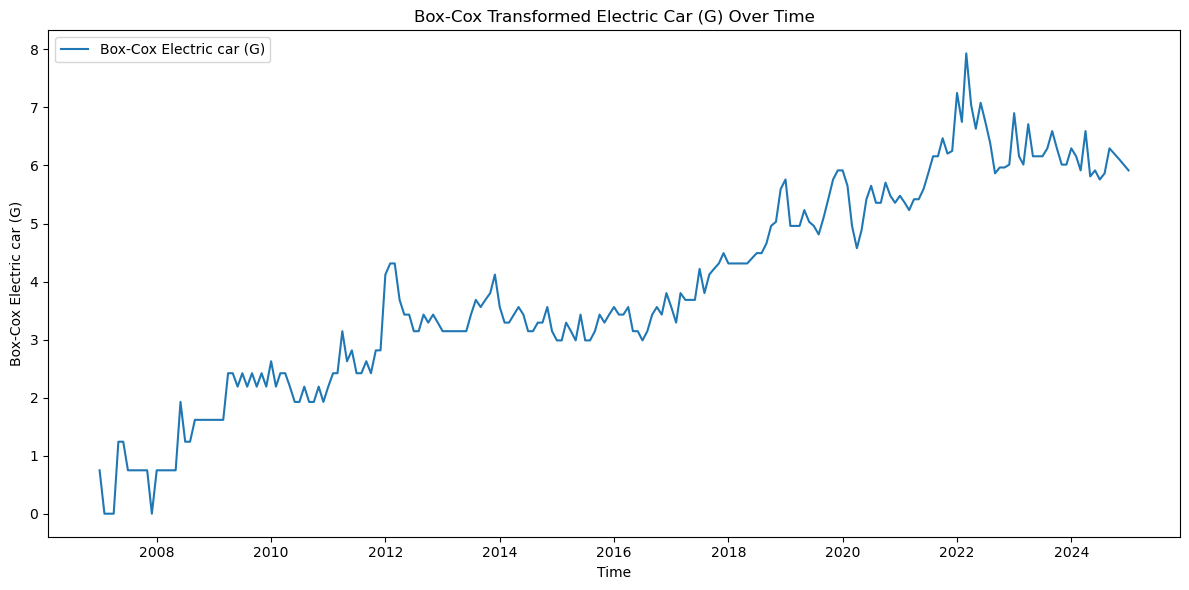

In [41]:
# Box-Cox transform for 'Electric car (G)'
electric_car_col = "Electric car (G)"
electric_car_values = df[electric_car_col].values

# Box-Cox requires strictly positive values, so add a small constant if needed
if (electric_car_values <= 0).any():
    electric_car_values_shifted = electric_car_values + 1
else:
    electric_car_values_shifted = electric_car_values

electric_car_boxcox, electric_car_lambda = boxcox(electric_car_values_shifted)

# Save transformed values to the DataFrame
df['BoxCox ' + electric_car_col] = electric_car_boxcox

print(f"Box-Cox lambda for '{electric_car_col}': {electric_car_lambda:.4f}")

plt.figure(figsize=(12, 6))
plt.plot(df.index, electric_car_boxcox, label="Box-Cox Electric car (G)")
plt.xlabel("Time")
plt.ylabel("Box-Cox Electric car (G)")
plt.title("Box-Cox Transformed Electric Car (G) Over Time")
plt.legend()
plt.tight_layout()
plt.show()

### 2. Stationarity Check

nPerform Augmented Dickey-Fuller test on Box-Cox trasformed x

In [42]:
# Perform Augmented Dickey-Fuller test on Box-Cox transformed Electric car (G)
adf_electric_car = adfuller(df['BoxCox Electric car (G)'])

print("ADF Statistic (Box-Cox Electric car): {:.4f}".format(adf_electric_car[0]))
print("p-value: {:.4f}".format(adf_electric_car[1]))
for key, value in adf_electric_car[4].items():
    print(f"Critical Value ({key}): {value:.4f}")

if adf_electric_car[1] < 0.05:
    print("The series is likely stationary (reject H0).")
else:
    print("The series is likely non-stationary (fail to reject H0).")

ADF Statistic (Box-Cox Electric car): -1.4389
p-value: 0.5635
Critical Value (1%): -3.4619
Critical Value (5%): -2.8754
Critical Value (10%): -2.5742
The series is likely non-stationary (fail to reject H0).


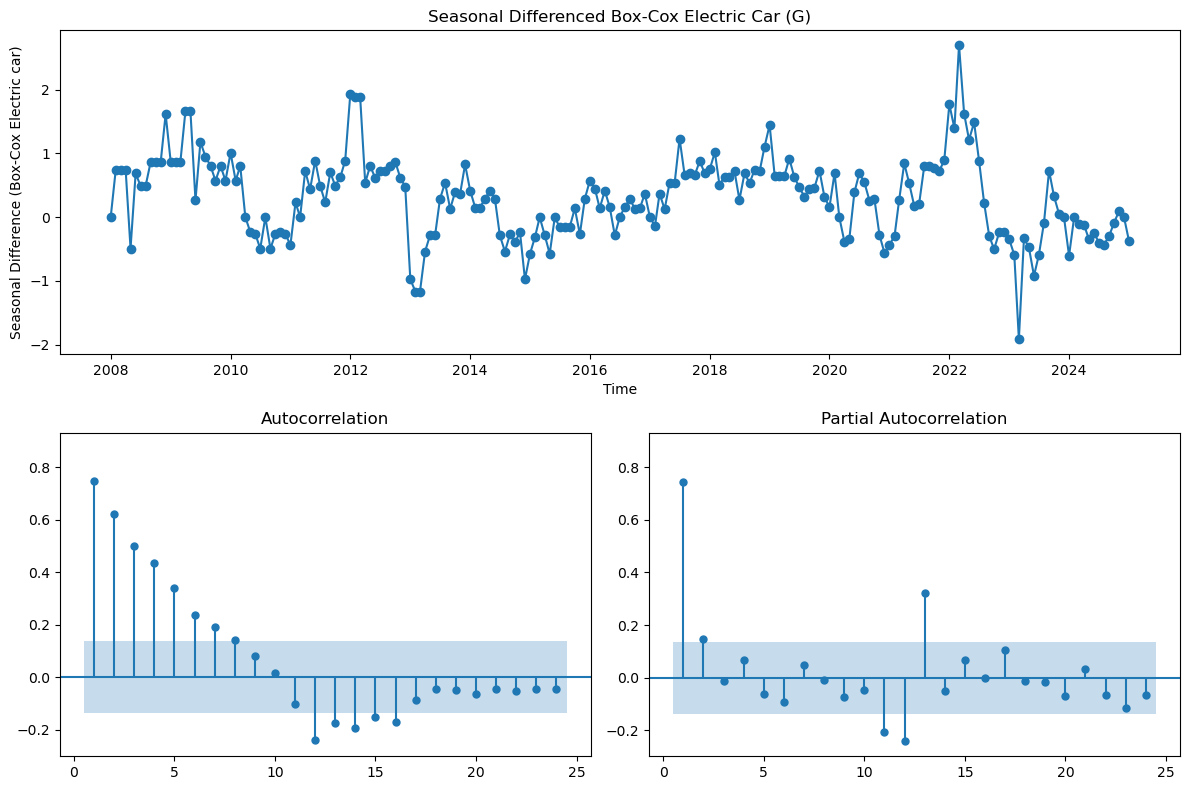

ADF Statistic (seasonal differenced): -3.1669
p-value: 0.0220
Critical Value (1%): -3.4649
Critical Value (5%): -2.8767
Critical Value (10%): -2.5749
The series is likely stationary (reject H0).


In [44]:
# Convert BoxCox Electric car (G) to Series to align with time index
electric_car_boxcox_series = pd.Series(electric_car_boxcox, index=df.index)

# Compute 12-lag seasonal difference
seasonal_diff_electric = electric_car_boxcox_series.diff(12).dropna()

# Create plots
fig = plt.figure(figsize=(12, 8))
gs = fig.add_gridspec(2, 2)
ax1 = fig.add_subplot(gs[0, :])
ax2 = fig.add_subplot(gs[1, 0])
ax3 = fig.add_subplot(gs[1, 1])

# Time-series plot
ax1.plot(df.index[12:], seasonal_diff_electric, marker="o")
ax1.set_ylabel("Seasonal Difference (Box-Cox Electric car)")
ax1.set_xlabel("Time")
ax1.set_title("Seasonal Differenced Box-Cox Electric Car (G)")

# ACF and PACF
plot_acf(seasonal_diff_electric, ax2, zero=False, lags=24, bartlett_confint=False, auto_ylims=True)
plot_pacf(seasonal_diff_electric, ax3, zero=False, lags=24, auto_ylims=True)
plt.tight_layout()
plt.show()

# ADF Test
adf_result_electric = adfuller(seasonal_diff_electric)

print("ADF Statistic (seasonal differenced): {:.4f}".format(adf_result_electric[0]))
print("p-value: {:.4f}".format(adf_result_electric[1]))
for key, value in adf_result_electric[4].items():
    print(f"Critical Value ({key}): {value:.4f}")

if adf_result_electric[1] < 0.05:
    print("The series is likely stationary (reject H0).")
else:
    print("The series is likely non-stationary (fail to reject H0).")


> since its stationary i will continue with splitting the data into train/validation/test sets

### 3. split data

In [46]:
# Align index if needed (should already be DatetimeIndex)
seasonal_diff_electric = seasonal_diff_electric.copy()
seasonal_diff_electric.index = df.index[-len(seasonal_diff_electric):]

# Calculate split indices
n = len(seasonal_diff_electric)
train_end = int(n * 0.8)
val_end = int(n * 0.9)

dates = seasonal_diff_electric.index
train_idx = dates[:train_end]
val_idx = dates[train_end:val_end]
test_idx = dates[val_end:]

# Split the series
electric_train = seasonal_diff_electric.loc[train_idx]
electric_val = seasonal_diff_electric.loc[val_idx]
electric_test = seasonal_diff_electric.loc[test_idx]

print(f"Train length: {len(electric_train)}")
print(f"Validation length: {len(electric_val)}")
print(f"Test length: {len(electric_test)}")


Train length: 164
Validation length: 20
Test length: 21


### 4. Univariate SARIMAX + Lag Testing Fit SARIMAX using one predictor at a time:

In [47]:
# Settings
max_lag = 20  # How many lags you'd like to test

# Ensure df is indexed by datetime and has freq set
if not isinstance(df.index, pd.DatetimeIndex):
    df = df.set_index("Time Period (T)")
if df.index.freq is None:
    df = df.asfreq("MS")  # Set to monthly start, adjust if your data is not monthly

target_series = df["BoxCox vehicles sold (Target)"].loc[electric_train.index]

# Store results
lag_results = []

for lag in range(0, max_lag + 1):
    # Create lagged exogenous variable
    if lag == 0:
        exog = electric_train.copy()
        label = "lag0"
        model_target = target_series
    else:
        exog = electric_train.shift(lag).dropna()
        model_target = target_series.loc[exog.index]
        label = f"lag{lag}"

    # Ensure both have DatetimeIndex and freq set
    exog.index = pd.DatetimeIndex(exog.index)
    model_target.index = pd.DatetimeIndex(model_target.index)
    if exog.index.freq is None:
        exog.index = exog.index.to_period("M").to_timestamp()
    if model_target.index.freq is None:
        model_target.index = model_target.index.to_period("M").to_timestamp()

    # Fit SARIMAX
    model = SARIMAX(
        model_target,
        exog=exog,
        order=(2, 0, 1),
        seasonal_order=(0, 1, 1, 12),
        enforce_stationarity=False,
        enforce_invertibility=False
    )

    results = model.fit(disp=False)

    # Log metrics
    lag_results.append({
        "Lag": label,
        "AIC": results.aic,
        "BIC": results.bic,
        "Coefficient p-value": results.pvalues.get(label, None),
        "Log Likelihood": results.llf
    })

# Compare results in a DataFrame
lag_df = pd.DataFrame(lag_results).sort_values("AIC")
print("\n📊 Lag Comparison Summary:")
print(lag_df)


📊 Lag Comparison Summary:
      Lag       AIC        BIC Coefficient p-value  Log Likelihood
10  lag10 -8.766569   8.345613                None       10.383285
0    lag0 -4.269409  13.294113                None        8.134705
1    lag1 -3.049239  14.470647                None        7.524619
11  lag11 -2.587374  14.477749                None        7.293687
16  lag16 -1.897780  14.926346                None        6.948890
15  lag15 -1.651153  15.221953                None        6.825577
2    lag2 -1.594903  15.881027                None        6.797451
17  lag17 -1.292963  15.481781                None        6.646481
12  lag12 -1.262931  15.754761                None        6.631465
14  lag14 -0.881514  16.040176                None        6.440757
13  lag13 -0.749510  16.220372                None        6.374755
3    lag3 -0.486924  16.944725                None        6.243462
8    lag8  0.000924  17.206131                None        5.999538
20  lag20  0.078707  16.702815     

c:\Users\dylan\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                                     SARIMAX Results                                      
Dep. Variable:      BoxCox vehicles sold (Target)   No. Observations:                  154
Model:             SARIMAX(2, 0, 1)x(0, 1, 1, 12)   Log Likelihood                  10.383
Date:                            Mon, 14 Jul 2025   AIC                             -8.767
Time:                                    12:31:35   BIC                              8.346
Sample:                                11-01-2008   HQIC                            -1.814
                                     - 08-01-2021                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
0             -0.1085      0.029     -3.704      0.000      -0.166      -0.051
ar.L1          1.2799      0.144   

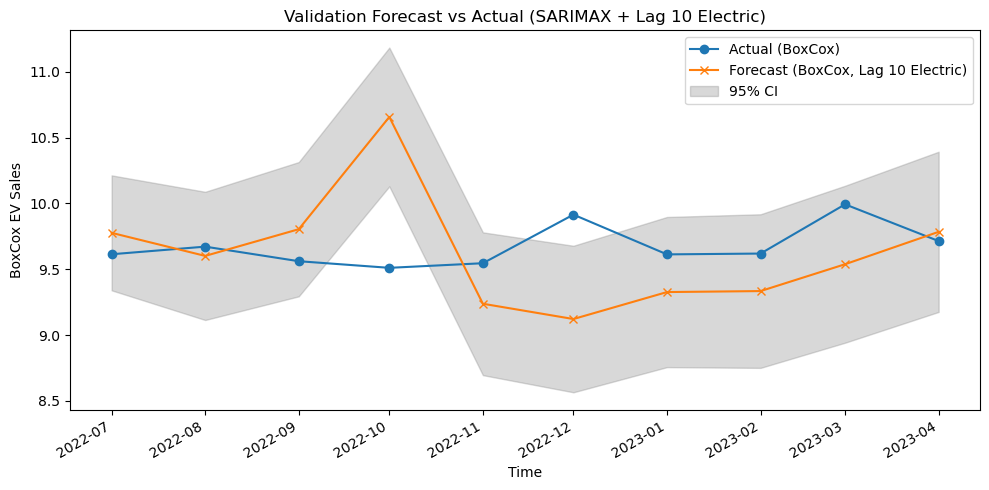

In [48]:
# Prepare lagged exogenous predictor for train/val split (Electric car, lag 10)
electric_lag10_train = electric_train.shift(10)
electric_lag10_val = electric_val.shift(10)

# Align with target and drop NaNs for training
train_mask = ~electric_lag10_train.isna()
electric_lag10_train_clean = electric_lag10_train[train_mask]
target_train_clean = target_train[train_mask]

# Fit SARIMAX model
model = SARIMAX(
    target_train_clean,
    exog=electric_lag10_train_clean,
    order=(2, 0, 1),
    seasonal_order=(0, 1, 1, 12),
    enforce_stationarity=False,
    enforce_invertibility=False
)
results = model.fit()
print(results.summary())

# Align validation exog and target (drop NaNs in exog)
val_mask = ~electric_lag10_val.isna()
electric_lag10_val_clean = electric_lag10_val[val_mask]
target_val_clean = target_val[val_mask]

# Forecast validation set
forecast = results.get_forecast(steps=len(electric_lag10_val_clean), exog=electric_lag10_val_clean)
preds = forecast.predicted_mean
conf_int = forecast.conf_int()

# Evaluate performance
rmse = np.sqrt(mean_squared_error(target_val_clean, preds))
mape = mean_absolute_percentage_error(target_val_clean, preds) * 100

print(f"\n📊 Forecast Evaluation (Validation Set):")
print(f"RMSE (BoxCox): {rmse:.4f}")
print(f"MAPE (BoxCox): {mape:.2f}%")

# Back-transform predictions and actuals to original scale
def inv_boxcox(y, lam):
    if abs(lam) < 1e-6:
        return np.exp(y)
    else:
        return np.power(lam * y + 1, 1 / lam)

preds_back = inv_boxcox(preds.values, fitted_lambda)
actuals_back = inv_boxcox(target_val_clean.values, fitted_lambda)

rmse_back = np.sqrt(mean_squared_error(actuals_back, preds_back))
mape_back = mean_absolute_percentage_error(actuals_back, preds_back) * 100

print(f"RMSE (Back-transformed): {rmse_back:.2f}")
print(f"MAPE (Back-transformed): {mape_back:.2f}%")

# Plot actual vs predicted
fig, ax = plt.subplots(figsize=(10, 5))
val_dates = target_val_clean.index
ax.plot(val_dates, target_val_clean, label="Actual (BoxCox)", marker='o')
ax.plot(val_dates, preds, label="Forecast (BoxCox, Lag 10 Electric)", marker='x')
ax.fill_between(val_dates, conf_int.iloc[:, 0], conf_int.iloc[:, 1], color='gray', alpha=0.3, label="95% CI")
ax.set_title("Validation Forecast vs Actual (SARIMAX + Lag 10 Electric)")
ax.set_xlabel("Time")
ax.set_ylabel("BoxCox EV Sales")
ax.legend()
ax.xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%Y-%m'))
fig.autofmt_xdate()
plt.tight_layout()
plt.show()


###  1. Data Cleaning & Transformation 
Home charging (G)'

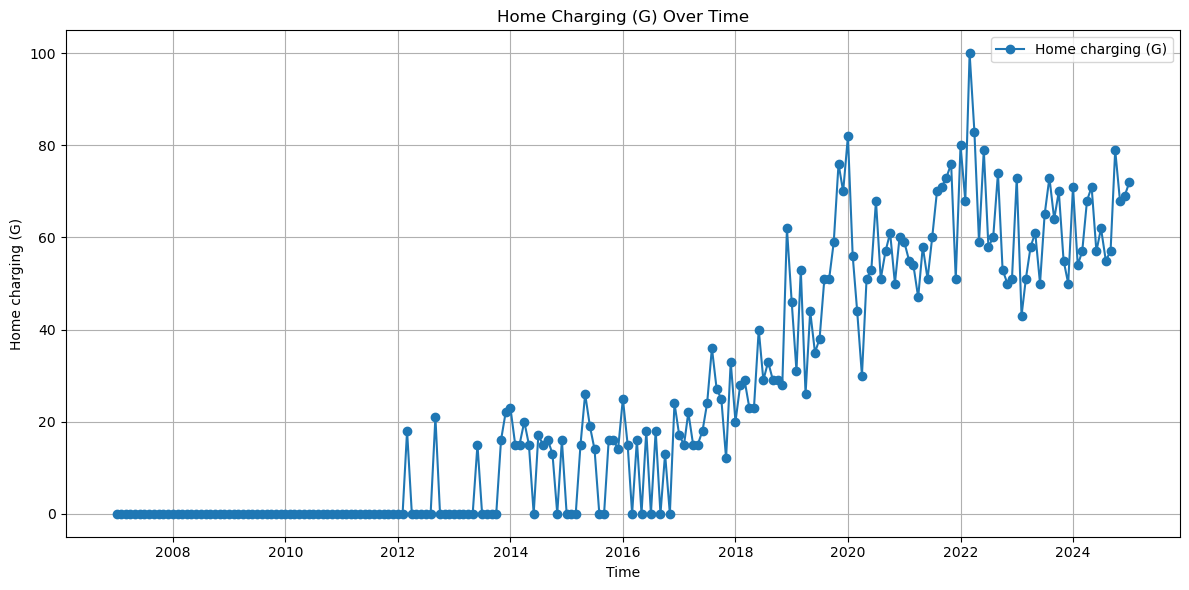

In [30]:
plt.figure(figsize=(12, 6))
plt.plot(df.index, df["Home charging (G)"], marker='o', label="Home charging (G)")
plt.xlabel("Time")
plt.ylabel("Home charging (G)")
plt.title("Home Charging (G) Over Time")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

a lot of varience in the data, so i will apply a box cox transformation to the data.

Box-Cox lambda for 'Home charging (G)': 0.1026


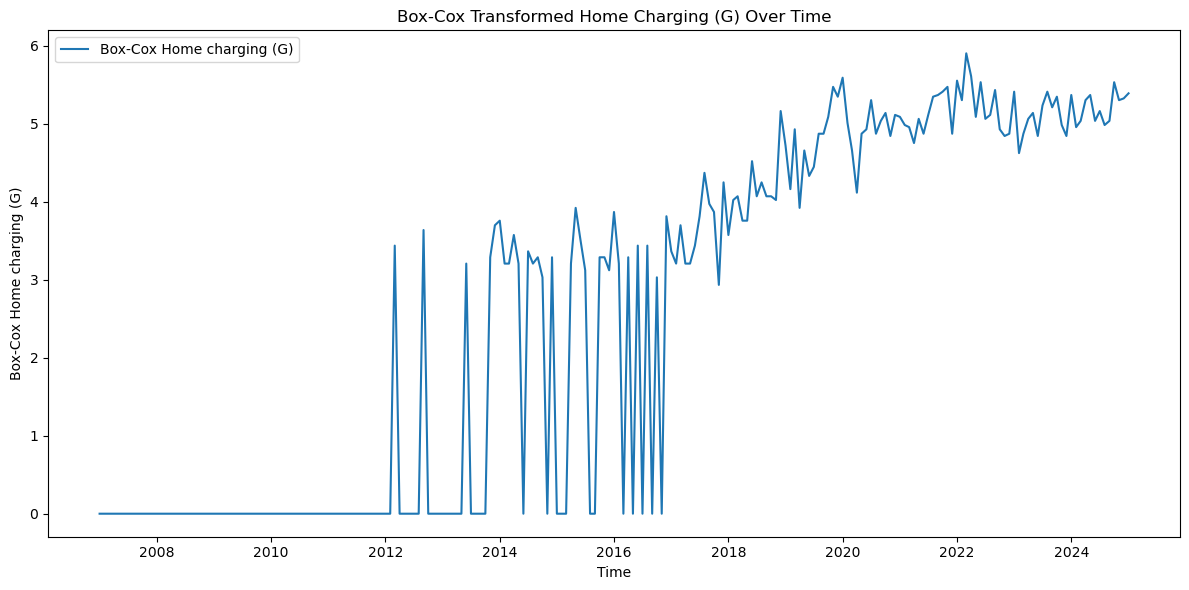

In [31]:
from scipy.stats import boxcox

# Select the column for transformation
home_charging_col = "Home charging (G)"
home_charging_values = df[home_charging_col].values

# Box-Cox requires strictly positive values, so add a small constant if needed
if (home_charging_values <= 0).any():
    home_charging_values_shifted = home_charging_values + 1
else:
    home_charging_values_shifted = home_charging_values

# Apply Box-Cox transformation
home_charging_boxcox, home_charging_lambda = boxcox(home_charging_values_shifted)

# Save transformed values to the DataFrame
df['BoxCox ' + home_charging_col] = home_charging_boxcox

print(f"Box-Cox lambda for '{home_charging_col}': {home_charging_lambda:.4f}")

plt.figure(figsize=(12, 6))
plt.plot(df.index, home_charging_boxcox, label="Box-Cox Home charging (G)")
plt.xlabel("Time")
plt.ylabel("Box-Cox Home charging (G)")
plt.title("Box-Cox Transformed Home Charging (G) Over Time")
plt.legend()
plt.tight_layout()
plt.show()

### 2. Stationarity Check

Perform Augmented Dickey-Fuller test on Box-Cox transformed x

In [32]:
# Perform Augmented Dickey-Fuller test on Box-Cox transformed Home charging (G)
adf_home_charging = adfuller(df['BoxCox Home charging (G)'])

print("ADF Statistic (Box-Cox Home charging): {:.4f}".format(adf_home_charging[0]))
print("p-value: {:.4f}".format(adf_home_charging[1]))
for key, value in adf_home_charging[4].items():
    print(f"Critical Value ({key}): {value:.4f}")

if adf_home_charging[1] < 0.05:
    print("The series is likely stationary (reject H0).")
else:
    print("The series is likely non-stationary (fail to reject H0).")

ADF Statistic (Box-Cox Home charging): -0.5257
p-value: 0.8869
Critical Value (1%): -3.4633
Critical Value (5%): -2.8760
Critical Value (10%): -2.5745
The series is likely non-stationary (fail to reject H0).


since its not stationary, i will apply a first difference 

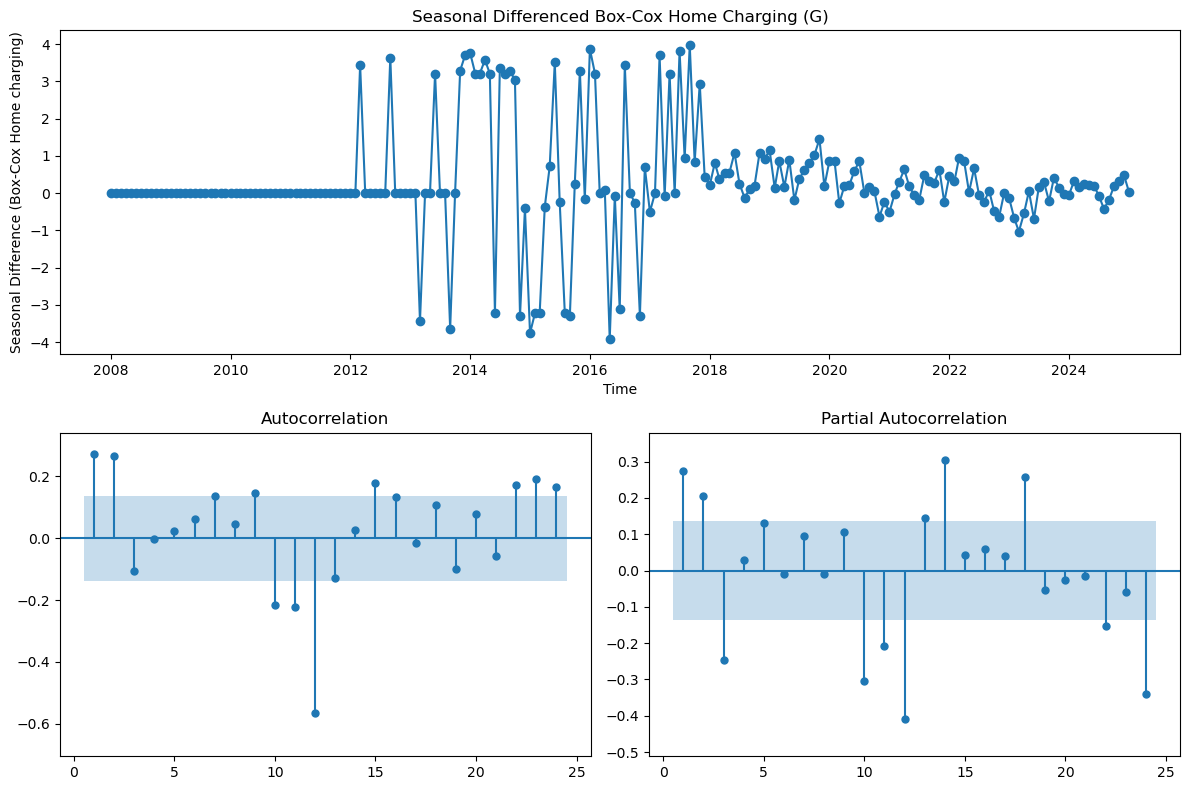

ADF Statistic (seasonal differenced): -3.8420
p-value: 0.0025
Critical Value (1%): -3.4651
Critical Value (5%): -2.8768
Critical Value (10%): -2.5749
The series is likely stationary (reject H0).


In [34]:
# Convert BoxCox Home charging (G) to Series to align with time index
home_charging_boxcox_series = pd.Series(home_charging_boxcox, index=df.index)

# Compute 12-lag seasonal difference
seasonal_diff_home = home_charging_boxcox_series.diff(12).dropna()

# Create plots
fig = plt.figure(figsize=(12, 8))
gs = fig.add_gridspec(2, 2)
ax1 = fig.add_subplot(gs[0, :])
ax2 = fig.add_subplot(gs[1, 0])
ax3 = fig.add_subplot(gs[1, 1])

# Time-series plot
ax1.plot(df.index[12:], seasonal_diff_home, marker="o")
ax1.set_ylabel("Seasonal Difference (Box-Cox Home charging)")
ax1.set_xlabel("Time")
ax1.set_title("Seasonal Differenced Box-Cox Home Charging (G)")

# ACF and PACF
plot_acf(seasonal_diff_home, ax2, zero=False, lags=24, bartlett_confint=False, auto_ylims=True)
plot_pacf(seasonal_diff_home, ax3, zero=False, lags=24, auto_ylims=True)
plt.tight_layout()
plt.show()

# ADF Test
adf_result_home = adfuller(seasonal_diff_home)

print("ADF Statistic (seasonal differenced): {:.4f}".format(adf_result_home[0]))
print("p-value: {:.4f}".format(adf_result_home[1]))
for key, value in adf_result_home[4].items():
    print(f"Critical Value ({key}): {value:.4f}")

if adf_result_home[1] < 0.05:
    print("The series is likely stationary (reject H0).")
else:
    print("The series is likely non-stationary (fail to reject H0).")


since its stationary i will continue with splitting the data into train/validation/test sets

### 3. split data

In [36]:
# Align index if needed (should already be DatetimeIndex)
seasonal_diff_home = seasonal_diff_home.copy()
seasonal_diff_home.index = df.index[-len(seasonal_diff_home):]

# Calculate split indices
n = len(seasonal_diff_home)
train_end = int(n * 0.8)
val_end = int(n * 0.9)

dates = seasonal_diff_home.index
train_idx = dates[:train_end]
val_idx = dates[train_end:val_end]
test_idx = dates[val_end:]

# Split the series
homechg_train = seasonal_diff_home.loc[train_idx]
homechg_val = seasonal_diff_home.loc[val_idx]
homechg_test = seasonal_diff_home.loc[test_idx]

print(f"Train length: {len(homechg_train)}")
print(f"Validation length: {len(homechg_val)}")
print(f"Test length: {len(homechg_test)}")


Train length: 164
Validation length: 20
Test length: 21


### 4. Univariate SARIMAX + Lag Testing Fit SARIMAX using one predictor at a time:

In [38]:
# Settings
max_lag = 20  # How many lags you'd like to test

# Ensure df is indexed by datetime and has freq set
if not isinstance(df.index, pd.DatetimeIndex):
    df = df.set_index("Time Period (T)")
if df.index.freq is None:
    df = df.asfreq("MS")  # Set to monthly start, adjust if your data is not monthly

target_series = df["BoxCox vehicles sold (Target)"].loc[homechg_train.index]

# Store results
lag_results = []

for lag in range(0, max_lag + 1):
    # Create lagged exogenous variable
    if lag == 0:
        exog = homechg_train.copy()
        label = "lag0"
        model_target = target_series
    else:
        exog = homechg_train.shift(lag).dropna()
        model_target = target_series.loc[exog.index]
        label = f"lag{lag}"

    # Ensure both have DatetimeIndex and freq set
    exog.index = pd.DatetimeIndex(exog.index)
    model_target.index = pd.DatetimeIndex(model_target.index)
    if exog.index.freq is None:
        exog.index = exog.index.to_period("M").to_timestamp()
    if model_target.index.freq is None:
        model_target.index = model_target.index.to_period("M").to_timestamp()

    # Fit SARIMAX
    model = SARIMAX(
        model_target,
        exog=exog,
        order=(2, 0, 1),
        seasonal_order=(0, 1, 1, 12),
        enforce_stationarity=False,
        enforce_invertibility=False
    )

    results = model.fit(disp=False)

    # Log metrics
    lag_results.append({
        "Lag": label,
        "AIC": results.aic,
        "BIC": results.bic,
        "Coefficient p-value": results.pvalues.get(label, None),
        "Log Likelihood": results.llf
    })

# Compare results in a DataFrame
lag_df = pd.DataFrame(lag_results).sort_values("AIC")
print("\n📊 Lag Comparison Summary:")
print(lag_df)


📊 Lag Comparison Summary:
      Lag       AIC        BIC Coefficient p-value  Log Likelihood
11  lag11 -5.869609  11.195513                None        8.934805
0    lag0 -2.470459  15.093063                None        7.235229
1    lag1 -1.610254  15.909632                None        6.805127
12  lag12 -1.599722  15.417970                None        6.799861
10  lag10 -1.355358  15.756823                None        6.677679
15  lag15 -1.209273  15.663833                None        6.604637
5    lag5 -1.191790  16.150305                None        6.595895
2    lag2 -1.086459  16.389470                None        6.543230
16  lag16 -1.011660  15.812467                None        6.505830
13  lag13 -0.899828  16.070055                None        6.449914
17  lag17 -0.563750  16.210993                None        6.281875
20  lag20 -0.284242  16.339866                None        6.142121
14  lag14 -0.269560  16.652130                None        6.134780
8    lag8 -0.268504  16.936703     

                                     SARIMAX Results                                      
Dep. Variable:      BoxCox vehicles sold (Target)   No. Observations:                  152
Model:             SARIMAX(2, 0, 1)x(0, 1, 1, 12)   Log Likelihood                   6.800
Date:                            Sat, 12 Jul 2025   AIC                             -1.600
Time:                                    17:21:42   BIC                             15.418
Sample:                                01-01-2009   HQIC                             5.314
                                     - 08-01-2021                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
0             -0.0048      0.010     -0.470      0.638      -0.025       0.015
ar.L1          1.2894      0.147   

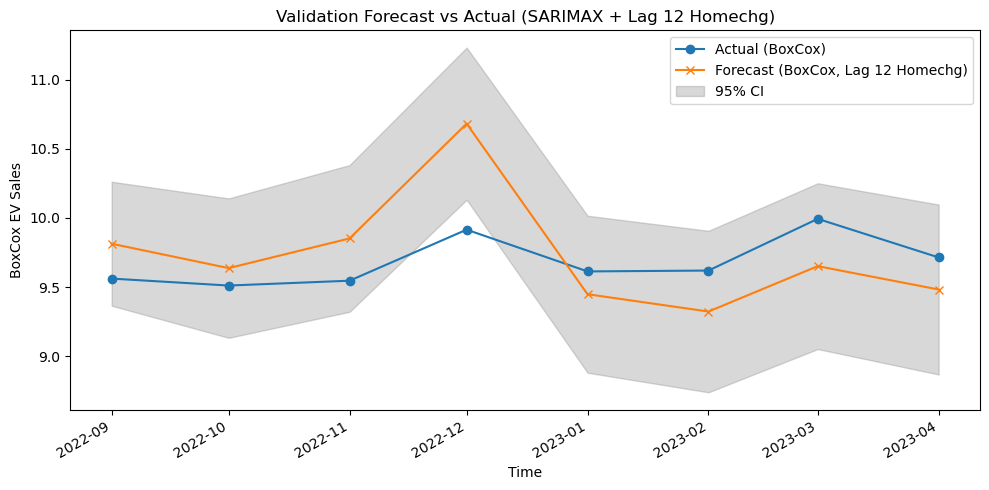

In [39]:
# Prepare lagged exogenous predictor for train/val split (Home charging, lag 12)
homechg_lag12_train = homechg_train.shift(12)
homechg_lag12_val = homechg_val.shift(12)

# Align with target and drop NaNs for training
train_mask = ~homechg_lag12_train.isna()
homechg_lag12_train_clean = homechg_lag12_train[train_mask]
target_train_clean = target_train[train_mask]

# Fit SARIMAX model
model = SARIMAX(
    target_train_clean,
    exog=homechg_lag12_train_clean,
    order=(2, 0, 1),
    seasonal_order=(0, 1, 1, 12),
    enforce_stationarity=False,
    enforce_invertibility=False
)
results = model.fit()
print(results.summary())

# Align validation exog and target (drop NaNs in exog)
val_mask = ~homechg_lag12_val.isna()
homechg_lag12_val_clean = homechg_lag12_val[val_mask]
target_val_clean = target_val[val_mask]

# Forecast validation set
forecast = results.get_forecast(steps=len(homechg_lag12_val_clean), exog=homechg_lag12_val_clean)
preds = forecast.predicted_mean
conf_int = forecast.conf_int()

# Evaluate performance
rmse = np.sqrt(mean_squared_error(target_val_clean, preds))
mape = mean_absolute_percentage_error(target_val_clean, preds) * 100

print(f"\n📊 Forecast Evaluation (Validation Set):")
print(f"RMSE (BoxCox): {rmse:.4f}")
print(f"MAPE (BoxCox): {mape:.2f}%")

# Back-transform predictions and actuals to original scale
def inv_boxcox(y, lam):
    if abs(lam) < 1e-6:
        return np.exp(y)
    else:
        return np.power(lam * y + 1, 1 / lam)

preds_back = inv_boxcox(preds.values, fitted_lambda)
actuals_back = inv_boxcox(target_val_clean.values, fitted_lambda)

rmse_back = np.sqrt(mean_squared_error(actuals_back, preds_back))
mape_back = mean_absolute_percentage_error(actuals_back, preds_back) * 100

print(f"RMSE (Back-transformed): {rmse_back:.2f}")
print(f"MAPE (Back-transformed): {mape_back:.2f}%")

# Plot actual vs predicted
fig, ax = plt.subplots(figsize=(10, 5))
val_dates = target_val_clean.index
ax.plot(val_dates, target_val_clean, label="Actual (BoxCox)", marker='o')
ax.plot(val_dates, preds, label="Forecast (BoxCox, Lag 12 Homechg)", marker='x')
ax.fill_between(val_dates, conf_int.iloc[:, 0], conf_int.iloc[:, 1], color='gray', alpha=0.3, label="95% CI")
ax.set_title("Validation Forecast vs Actual (SARIMAX + Lag 12 Homechg)")
ax.set_xlabel("Time")
ax.set_ylabel("BoxCox EV Sales")
ax.legend()
ax.xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%Y-%m'))
fig.autofmt_xdate()
plt.tight_layout()
plt.show()


### 5. Then try combining all three:
Use a SARIMAX model with multiple exog variables

Watch out for multicollinearity (flattened ACFs are a hint!)

Use statsmodels Variance Inflation Factor (VIF) or .summary() to inspect coefficient stability

3️⃣ Compare model fit:

If the combined model yields significantly better AICc and forecast accuracy, you keep the trio.

Otherwise, just retain top performers individually.

                                     SARIMAX Results                                      
Dep. Variable:      BoxCox vehicles sold (Target)   No. Observations:                  152
Model:             SARIMAX(2, 0, 1)x(0, 1, 1, 12)   Log Likelihood                  11.317
Date:                            Mon, 14 Jul 2025   AIC                             -6.634
Time:                                    13:43:35   BIC                             16.056
Sample:                                01-01-2009   HQIC                             2.584
                                     - 08-01-2021                                         
Covariance Type:                              opg                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
homechg_lag12     -0.0017      0.009     -0.178      0.859      -0.020       0.017
electric_lag10    -0.11

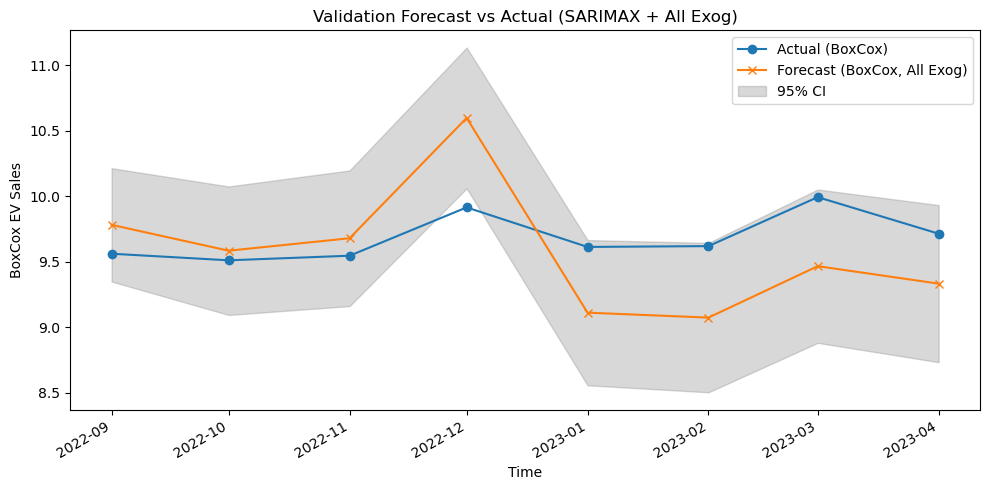

<Figure size 800x400 with 0 Axes>

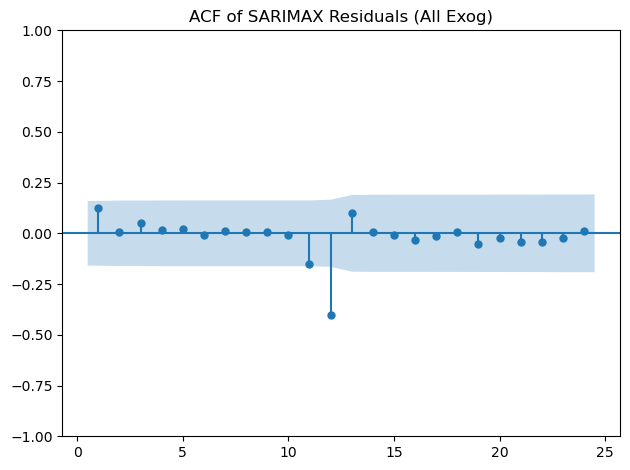


Variance Inflation Factors (VIF):
         Variable       VIF
0   homechg_lag12  1.062061
1  electric_lag10  1.053143
2     hybrid_lag0  1.009542


In [63]:
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Combine all three exogenous features for train/validation (align by dropping any rows with NaN in any exog)
exog_train_all = pd.concat(
    [homechg_lag12_train, electric_lag10_train, hybrid_lag0_train], axis=1
).dropna()
exog_train_all.columns = ['homechg_lag12', 'electric_lag10', 'hybrid_lag0']

# Align target to exog_train_all index
target_train_all = target_train.loc[exog_train_all.index]

# Same for validation set
exog_val_all = pd.concat(
    [homechg_lag12_val, electric_lag10_val, hybrid_lag0_val], axis=1
).dropna()
exog_val_all.columns = ['homechg_lag12', 'electric_lag10', 'hybrid_lag0']
target_val_all = target_val.loc[exog_val_all.index]

# Fit SARIMAX with all three exogenous variables
model = SARIMAX(
    target_train_all,
    exog=exog_train_all,
    order=(2, 0, 1),
    seasonal_order=(0, 1, 1, 12),
    enforce_stationarity=False,
    enforce_invertibility=False
)
results = model.fit()
print(results.summary())

# Forecast on validation set
forecast = results.get_forecast(steps=len(exog_val_all), exog=exog_val_all)
preds = forecast.predicted_mean
conf_int = forecast.conf_int()

# Evaluate performance
rmse = np.sqrt(mean_squared_error(target_val_all, preds))
mape = mean_absolute_percentage_error(target_val_all, preds) * 100

print(f"\n📊 Forecast Evaluation (Validation Set):")
print(f"RMSE (BoxCox): {rmse:.4f}")
print(f"MAPE (BoxCox): {mape:.2f}%")

# Back-transform predictions and actuals to original scale
def inv_boxcox(y, lam):
    if abs(lam) < 1e-6:
        return np.exp(y)
    else:
        return np.power(lam * y + 1, 1 / lam)

preds_back = inv_boxcox(preds.values, fitted_lambda)
actuals_back = inv_boxcox(target_val_all.values, fitted_lambda)

rmse_back = np.sqrt(mean_squared_error(actuals_back, preds_back))
mape_back = mean_absolute_percentage_error(actuals_back, preds_back) * 100

print(f"RMSE (Back-transformed): {rmse_back:.2f}")
print(f"MAPE (Back-transformed): {mape_back:.2f}%")

# Plot actual vs predicted
fig, ax = plt.subplots(figsize=(10, 5))
val_dates = target_val_all.index
ax.plot(val_dates, target_val_all, label="Actual (BoxCox)", marker='o')
ax.plot(val_dates, preds, label="Forecast (BoxCox, All Exog)", marker='x')
ax.fill_between(val_dates, conf_int.iloc[:, 0], conf_int.iloc[:, 1], color='gray', alpha=0.3, label="95% CI")
ax.set_title("Validation Forecast vs Actual (SARIMAX + All Exog)")
ax.set_xlabel("Time")
ax.set_ylabel("BoxCox EV Sales")
ax.legend()
ax.xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%Y-%m'))
fig.autofmt_xdate()
plt.tight_layout()
plt.show()

# Plot ACF of residuals

residuals = results.resid
plt.figure(figsize=(8, 4))
plot_acf(residuals, lags=24, zero=False)
plt.title("ACF of SARIMAX Residuals (All Exog)")
plt.tight_layout()
plt.show()

# VIF test for multicollinearity

# VIF expects no NaNs and a numpy array
vif_data = exog_train_all.values
vif_df = pd.DataFrame({
    "Variable": exog_train_all.columns,
    "VIF": [variance_inflation_factor(vif_data, i) for i in range(vif_data.shape[1])]
})
print("\nVariance Inflation Factors (VIF):")
print(vif_df)

| Feature           | Coefficient | p-value | Status            |
|------------------|-------------|---------|-------------------|
| Home Charging (lag 12)  | -0.0017     | 0.859   | ❌ Not significant |
| Electric Car (lag 10)   | -0.1149     | 0.000   | ✅ Significant     |
| Hybrid Electric (lag 0) | +0.0022     | 0.863   | ❌ Not significant |

**Key takeaway:** Only *Electric Car* search term at lag 10 shows strong predictive power. The others likely don’t add meaningful signal.
| Predictor        | VIF   | Safe?         |
|------------------|-------|----------------|
| Home Charging    | 1.06  | ✅ Yes         |
| Electric Car     | 1.05  | ✅ Yes         |
| Hybrid Electric  | 1.01  | ✅ Yes         |

VIF values are all well below 5 → no multicollinearity concerns.


# - Consumer confidence:
    'Consumer confidence (E)', 'Economic climate perception (E)', 'Willingness to buy (E)'


# 'Consumer confidence (E)

### 1. Data Cleaning & Transformation --> Apply Box-Cox or log transform

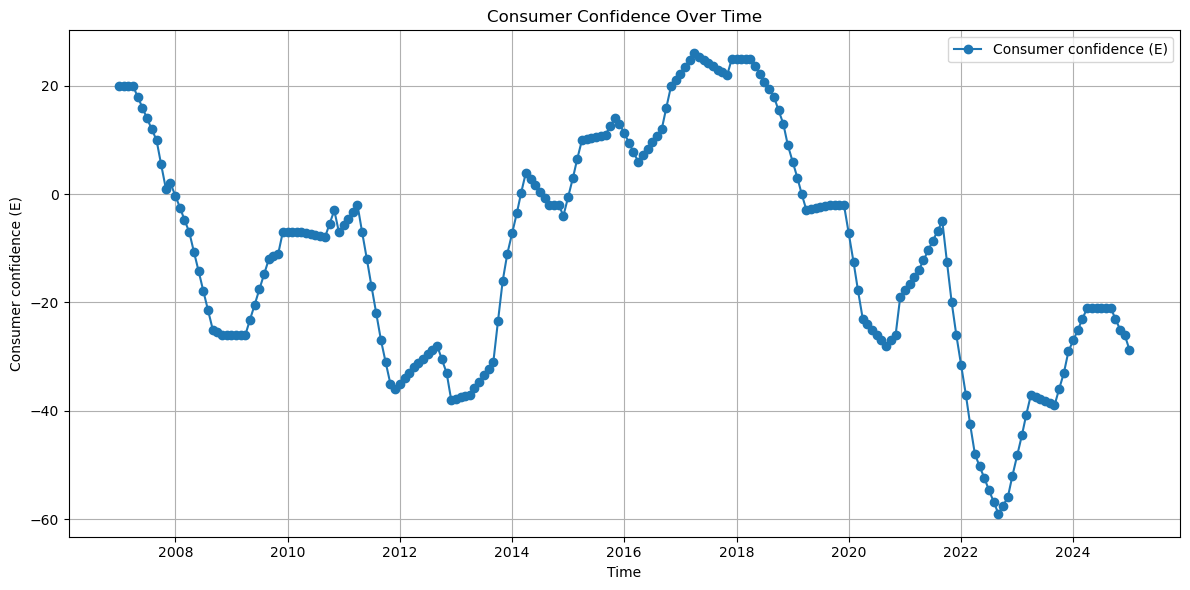

In [64]:
plt.figure(figsize=(12, 6))
plt.plot(df.index, df["Consumer confidence (E)"], marker='o', label="Consumer confidence (E)")
plt.xlabel("Time")
plt.ylabel("Consumer confidence (E)")
plt.title("Consumer Confidence Over Time")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Box-Cox lambda for 'Consumer confidence (E)': 0.9074


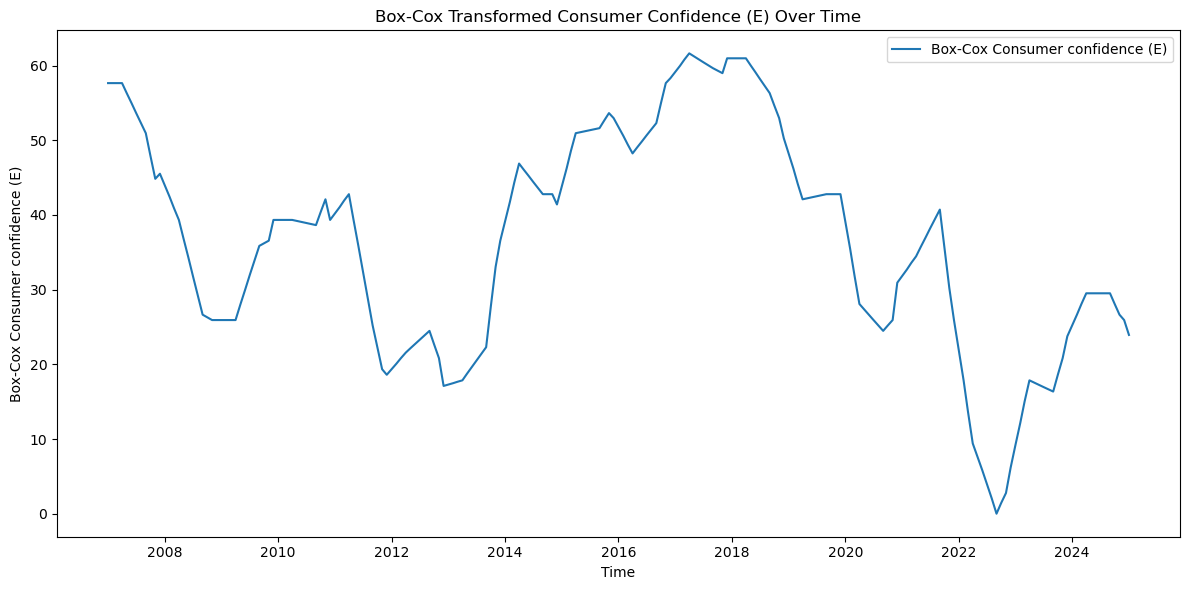

In [66]:
# Box-Cox transform for 'Consumer confidence (E)'
consumer_conf_col = "Consumer confidence (E)"
consumer_conf_values = df[consumer_conf_col].values

# Box-Cox requires strictly positive values, so add a constant if needed
if (consumer_conf_values <= 0).any():
    consumer_conf_values_shifted = consumer_conf_values - consumer_conf_values.min() + 1
else:
    consumer_conf_values_shifted = consumer_conf_values

consumer_conf_boxcox, consumer_conf_lambda = boxcox(consumer_conf_values_shifted)

# Save transformed values to the DataFrame
df['BoxCox ' + consumer_conf_col] = consumer_conf_boxcox

print(f"Box-Cox lambda for '{consumer_conf_col}': {consumer_conf_lambda:.4f}")

plt.figure(figsize=(12, 6))
plt.plot(df.index, consumer_conf_boxcox, label="Box-Cox Consumer confidence (E)")
plt.xlabel("Time")
plt.ylabel("Box-Cox Consumer confidence (E)")
plt.title("Box-Cox Transformed Consumer Confidence (E) Over Time")
plt.legend()
plt.tight_layout()
plt.show()

### 2. Stationarity Check

In [67]:
# Perform Augmented Dickey-Fuller test on Box-Cox transformed Consumer confidence (E)
adf_consumer_conf = adfuller(consumer_conf_boxcox)

print("ADF Statistic (Box-Cox Consumer confidence): {:.4f}".format(adf_consumer_conf[0]))
print("p-value: {:.4f}".format(adf_consumer_conf[1]))
for key, value in adf_consumer_conf[4].items():
    print(f"Critical Value ({key}): {value:.4f}")

if adf_consumer_conf[1] < 0.05:
    print("The series is likely stationary (reject H0).")
else:
    print("The series is likely non-stationary (fail to reject H0).")

ADF Statistic (Box-Cox Consumer confidence): -2.5215
p-value: 0.1103
Critical Value (1%): -3.4611
Critical Value (5%): -2.8751
Critical Value (10%): -2.5740
The series is likely non-stationary (fail to reject H0).


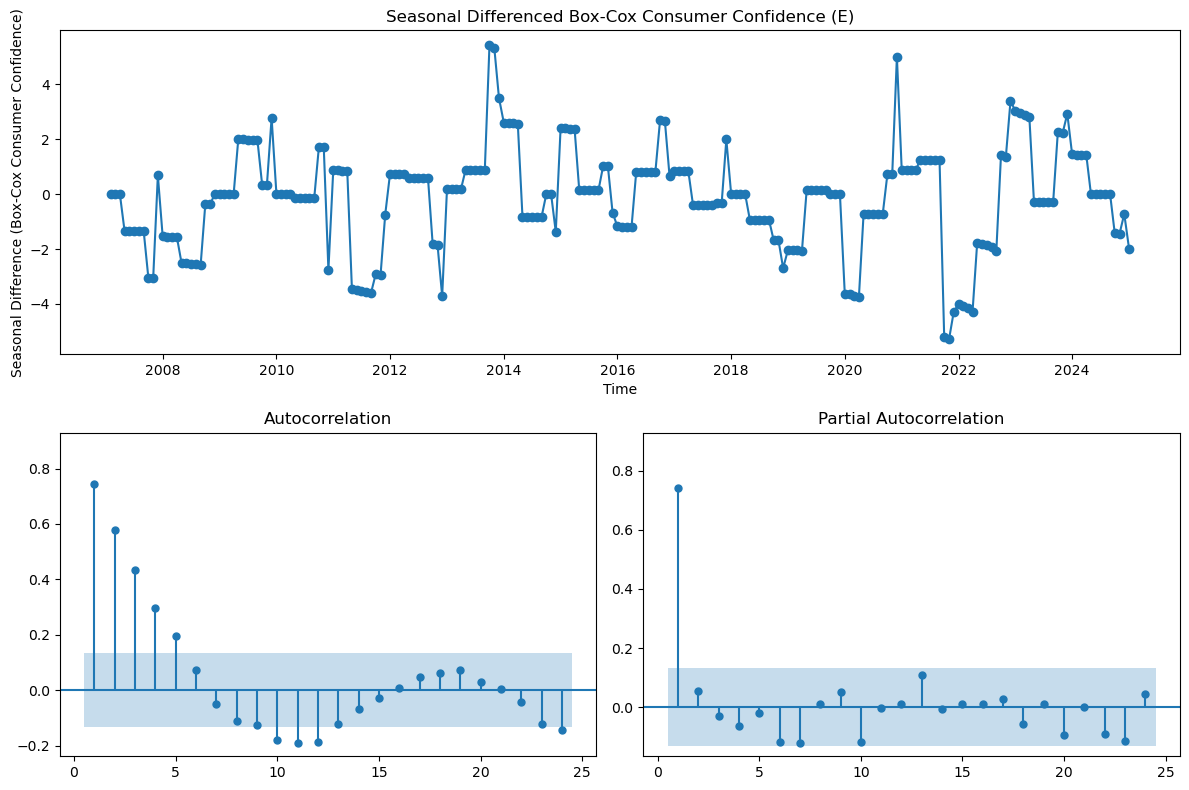

ADF Statistic (seasonal differenced): -5.5259
p-value: 0.0000
Critical Value (1%): -3.4611
Critical Value (5%): -2.8751
Critical Value (10%): -2.5740
The series is likely stationary (reject H0).


In [78]:
# Convert BoxCox Consumer confidence (E) to Series to align with time index
consumer_conf_boxcox_series = pd.Series(consumer_conf_boxcox, index=df.index)

# Compute 12-lag seasonal difference
seasonal_diff_cons_conf = consumer_conf_boxcox_series.diff(1).dropna()

# Create plots
fig = plt.figure(figsize=(12, 8))
gs = fig.add_gridspec(2, 2)
ax1 = fig.add_subplot(gs[0, :])
ax2 = fig.add_subplot(gs[1, 0])
ax3 = fig.add_subplot(gs[1, 1])

# Time-series plot
ax1.plot(df.index[1:], seasonal_diff_cons_conf, marker="o")
ax1.set_ylabel("Seasonal Difference (Box-Cox Consumer Confidence)")
ax1.set_xlabel("Time")
ax1.set_title("Seasonal Differenced Box-Cox Consumer Confidence (E)")

# ACF and PACF
plot_acf(seasonal_diff_cons_conf, ax2, zero=False, lags=24, bartlett_confint=False, auto_ylims=True)
plot_pacf(seasonal_diff_cons_conf, ax3, zero=False, lags=24, auto_ylims=True)
plt.tight_layout()
plt.show()

# ADF Test
adf_result_cons_conf = adfuller(seasonal_diff_cons_conf)

print("ADF Statistic (seasonal differenced): {:.4f}".format(adf_result_cons_conf[0]))
print("p-value: {:.4f}".format(adf_result_cons_conf[1]))
for key, value in adf_result_cons_conf[4].items():
    print(f"Critical Value ({key}): {value:.4f}")

if adf_result_cons_conf[1] < 0.05:
    print("The series is likely stationary (reject H0).")
else:
    print("The series is likely non-stationary (fail to reject H0).")

now its stationary we can continue with splitting the data into train/validation/test sets

### 3. Split Data

lets do 80/10/10 split for train/validation/test sets

In [79]:
# Align index if needed (should already be DatetimeIndex)
seasonal_diff_cons_conf = seasonal_diff_cons_conf.copy()
seasonal_diff_cons_conf.index = df.index[-len(seasonal_diff_cons_conf):]

# Calculate split indices
n = len(seasonal_diff_cons_conf)
train_end = int(n * 0.8)
val_end = int(n * 0.9)

dates = seasonal_diff_cons_conf.index
train_idx = dates[:train_end]
val_idx = dates[train_end:val_end]
test_idx = dates[val_end:]

# Split the series
consconf_train = seasonal_diff_cons_conf.loc[train_idx]
consconf_val = seasonal_diff_cons_conf.loc[val_idx]
consconf_test = seasonal_diff_cons_conf.loc[test_idx]

print(f"Train length: {len(consconf_train)}")
print(f"Validation length: {len(consconf_val)}")
print(f"Test length: {len(consconf_test)}")

Train length: 172
Validation length: 22
Test length: 22


### 4. Fit SARIMA model on the training set

In [81]:
# Settings
max_lag = 5  # How many lags you'd like to test

# Ensure df is indexed by datetime and has freq set
if not isinstance(df.index, pd.DatetimeIndex):
    df = df.set_index("Time Period (T)")
if df.index.freq is None:
    df = df.asfreq("MS")  # Set to monthly start, adjust if your data is not monthly

target_series = df["BoxCox vehicles sold (Target)"].loc[consconf_train.index]

# Store results
lag_results = []

for lag in range(0, max_lag + 1):
    # Create lagged exogenous variable
    if lag == 0:
        exog = consconf_train.copy()
        label = "lag0"
        model_target = target_series
    else:
        exog = consconf_train.shift(lag).dropna()
        model_target = target_series.loc[exog.index]
        label = f"lag{lag}"

    # Ensure both have DatetimeIndex and freq set
    exog.index = pd.DatetimeIndex(exog.index)
    model_target.index = pd.DatetimeIndex(model_target.index)
    if exog.index.freq is None:
        exog.index = exog.index.to_period("M").to_timestamp()
    if model_target.index.freq is None:
        model_target.index = model_target.index.to_period("M").to_timestamp()

    # Fit SARIMAX
    model = SARIMAX(
        model_target,
        exog=exog,
        order=(2, 0, 1),
        seasonal_order=(0, 1, 1, 12),
        enforce_stationarity=False,
        enforce_invertibility=False
    )

    results = model.fit(disp=False)

    # Log metrics
    lag_results.append({
        "Lag": label,
        "AIC": results.aic,
        "BIC": results.bic,
        "Coefficient p-value": results.pvalues.get(label, None),
        "Log Likelihood": results.llf
    })

# Compare results in a DataFrame
lag_df = pd.DataFrame(lag_results).sort_values("AIC")
print("\n📊 Lag Comparison Summary:")
print(lag_df)


📊 Lag Comparison Summary:
    Lag       AIC        BIC Coefficient p-value  Log Likelihood
0  lag0 -8.319309   9.582331                None       10.159655
2  lag2 -7.455984  10.362895                None        9.727992
3  lag3 -7.409302  10.367766                None        9.704651
5  lag5 -5.901421  11.791138                None        8.950711
1  lag1 -5.827960  12.032443                None        8.913980
4  lag4 -5.456715  12.278247                None        8.728358


### 5. evaluate model/ combine model

                                     SARIMAX Results                                      
Dep. Variable:      BoxCox vehicles sold (Target)   No. Observations:                  172
Model:             SARIMAX(2, 0, 1)x(0, 1, 1, 12)   Log Likelihood                  10.160
Date:                            Mon, 14 Jul 2025   AIC                             -8.319
Time:                                    14:31:02   BIC                              9.582
Sample:                                02-01-2007   HQIC                            -1.045
                                     - 05-01-2021                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
0              0.0162      0.011      1.483      0.138      -0.005       0.038
ar.L1          1.2014      0.141   

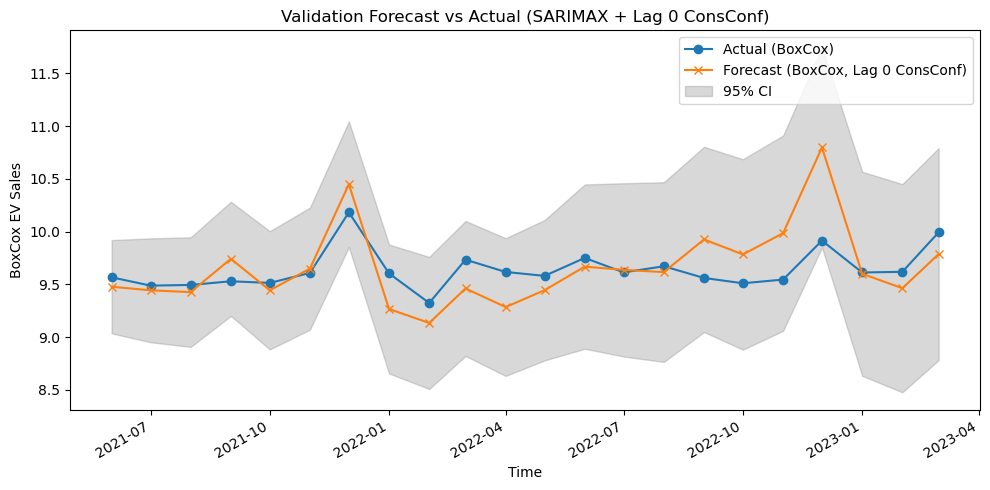

In [84]:
# Prepare exogenous predictor for train/val split (Consumer confidence, lag 0)
consconf_lag0_train = consconf_train  # lag 0, so no shift
consconf_lag0_val = consconf_val     # lag 0, so no shift

# Align target to exog index for training
target_train_clean = df["BoxCox vehicles sold (Target)"].loc[consconf_lag0_train.index]
consconf_lag0_train_clean = consconf_lag0_train

# Fit SARIMAX model
model = SARIMAX(
    target_train_clean,
    exog=consconf_lag0_train_clean,
    order=(2, 0, 1),
    seasonal_order=(0, 1, 1, 12),
    enforce_stationarity=False,
    enforce_invertibility=False
)
results = model.fit()
print(results.summary())

# Align validation exog and target
target_val_clean = df["BoxCox vehicles sold (Target)"].loc[consconf_lag0_val.index]
consconf_lag0_val_clean = consconf_lag0_val

# Forecast validation set
forecast = results.get_forecast(steps=len(consconf_lag0_val_clean), exog=consconf_lag0_val_clean)
preds = forecast.predicted_mean
conf_int = forecast.conf_int()

# Evaluate performance
rmse = np.sqrt(mean_squared_error(target_val_clean, preds))
mape = mean_absolute_percentage_error(target_val_clean, preds) * 100

print(f"\n📊 Forecast Evaluation (Validation Set):")
print(f"RMSE (BoxCox): {rmse:.4f}")
print(f"MAPE (BoxCox): {mape:.2f}%")

# Back-transform predictions and actuals to original scale
def inv_boxcox(y, lam):
    if abs(lam) < 1e-6:
        return np.exp(y)
    else:
        return np.power(lam * y + 1, 1 / lam)

preds_back = inv_boxcox(preds.values, fitted_lambda)
actuals_back = inv_boxcox(target_val_clean.values, fitted_lambda)

rmse_back = np.sqrt(mean_squared_error(actuals_back, preds_back))
mape_back = mean_absolute_percentage_error(actuals_back, preds_back) * 100

print(f"RMSE (Back-transformed): {rmse_back:.2f}")
print(f"MAPE (Back-transformed): {mape_back:.2f}%")

# Plot actual vs predicted
fig, ax = plt.subplots(figsize=(10, 5))
val_dates = target_val_clean.index
ax.plot(val_dates, target_val_clean, label="Actual (BoxCox)", marker='o')
ax.plot(val_dates, preds, label="Forecast (BoxCox, Lag 0 ConsConf)", marker='x')
ax.fill_between(val_dates, conf_int.iloc[:, 0], conf_int.iloc[:, 1], color='gray', alpha=0.3, label="95% CI")
ax.set_title("Validation Forecast vs Actual (SARIMAX + Lag 0 ConsConf)")
ax.set_xlabel("Time")
ax.set_ylabel("BoxCox EV Sales")
ax.legend()
ax.xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%Y-%m'))
fig.autofmt_xdate()
plt.tight_layout()
plt.show()

# 'Economic climate perception (E)

### 1. Data Cleaning & Transformation --> Apply Box-Cox or log transform

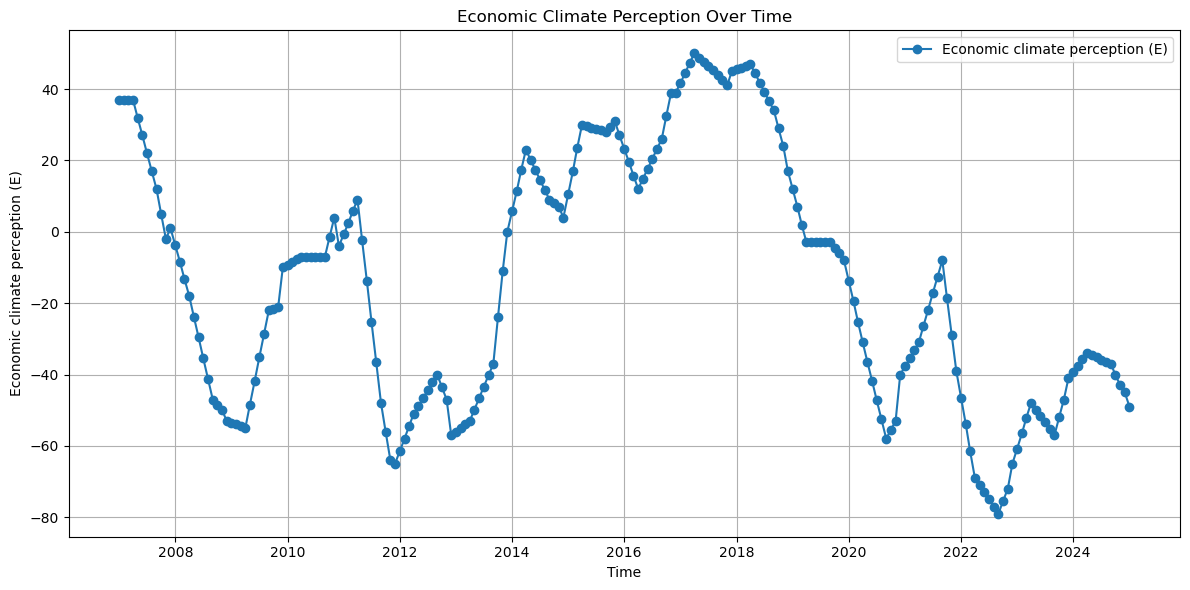

In [85]:
plt.figure(figsize=(12, 6))
plt.plot(df.index, df["Economic climate perception (E)"], marker='o', label="Economic climate perception (E)")
plt.xlabel("Time")
plt.ylabel("Economic climate perception (E)")
plt.title("Economic Climate Perception Over Time")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Box-Cox lambda for 'Economic climate perception (E)': 0.6438


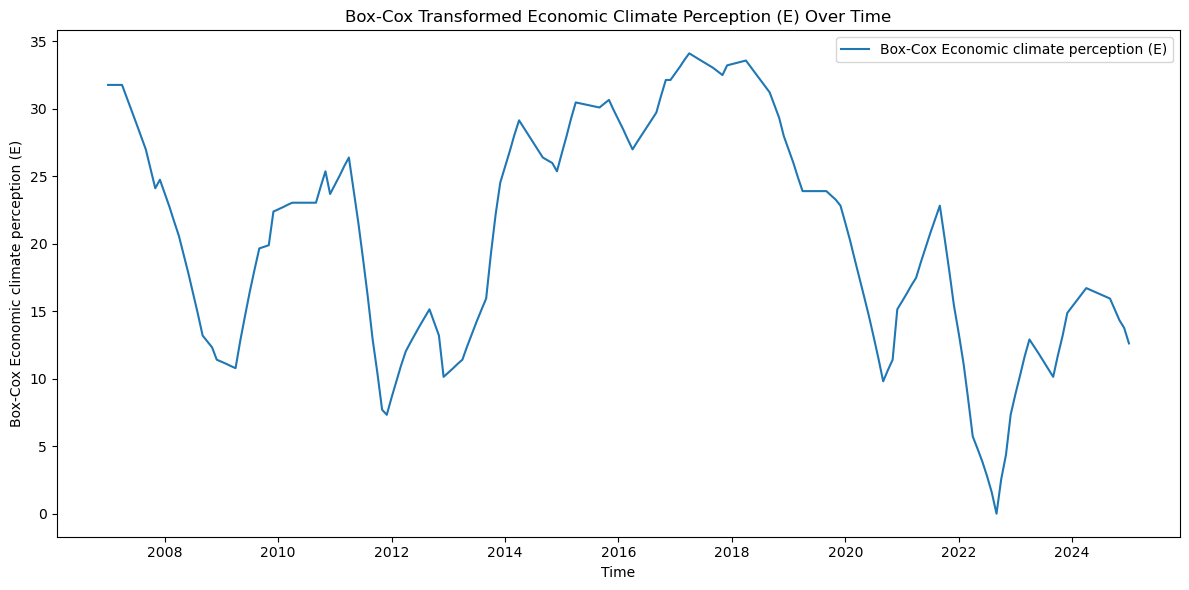

In [86]:
# Box-Cox transform for 'Economic climate perception (E)'
econ_climate_col = "Economic climate perception (E)"
econ_climate_values = df[econ_climate_col].values

# Box-Cox requires strictly positive values, so add a constant if needed
if (econ_climate_values <= 0).any():
    econ_climate_values_shifted = econ_climate_values - econ_climate_values.min() + 1
else:
    econ_climate_values_shifted = econ_climate_values

econ_climate_boxcox, econ_climate_lambda = boxcox(econ_climate_values_shifted)

# Save transformed values to the DataFrame
df['BoxCox ' + econ_climate_col] = econ_climate_boxcox

print(f"Box-Cox lambda for '{econ_climate_col}': {econ_climate_lambda:.4f}")

plt.figure(figsize=(12, 6))
plt.plot(df.index, econ_climate_boxcox, label="Box-Cox Economic climate perception (E)")
plt.xlabel("Time")
plt.ylabel("Box-Cox Economic climate perception (E)")
plt.title("Box-Cox Transformed Economic Climate Perception (E) Over Time")
plt.legend()
plt.tight_layout()
plt.show()

### 2. Stationarity Check

In [87]:
# Perform Augmented Dickey-Fuller test on Box-Cox transformed Economic climate perception (E)
adf_econ_climate = adfuller(econ_climate_boxcox)

print("ADF Statistic (Box-Cox Economic climate perception): {:.4f}".format(adf_econ_climate[0]))
print("p-value: {:.4f}".format(adf_econ_climate[1]))
for key, value in adf_econ_climate[4].items():
    print(f"Critical Value ({key}): {value:.4f}")

if adf_econ_climate[1] < 0.05:
    print("The series is likely stationary (reject H0).")
else:
    print("The series is likely non-stationary (fail to reject H0).")

ADF Statistic (Box-Cox Economic climate perception): -1.9958
p-value: 0.2884
Critical Value (1%): -3.4630
Critical Value (5%): -2.8759
Critical Value (10%): -2.5744
The series is likely non-stationary (fail to reject H0).


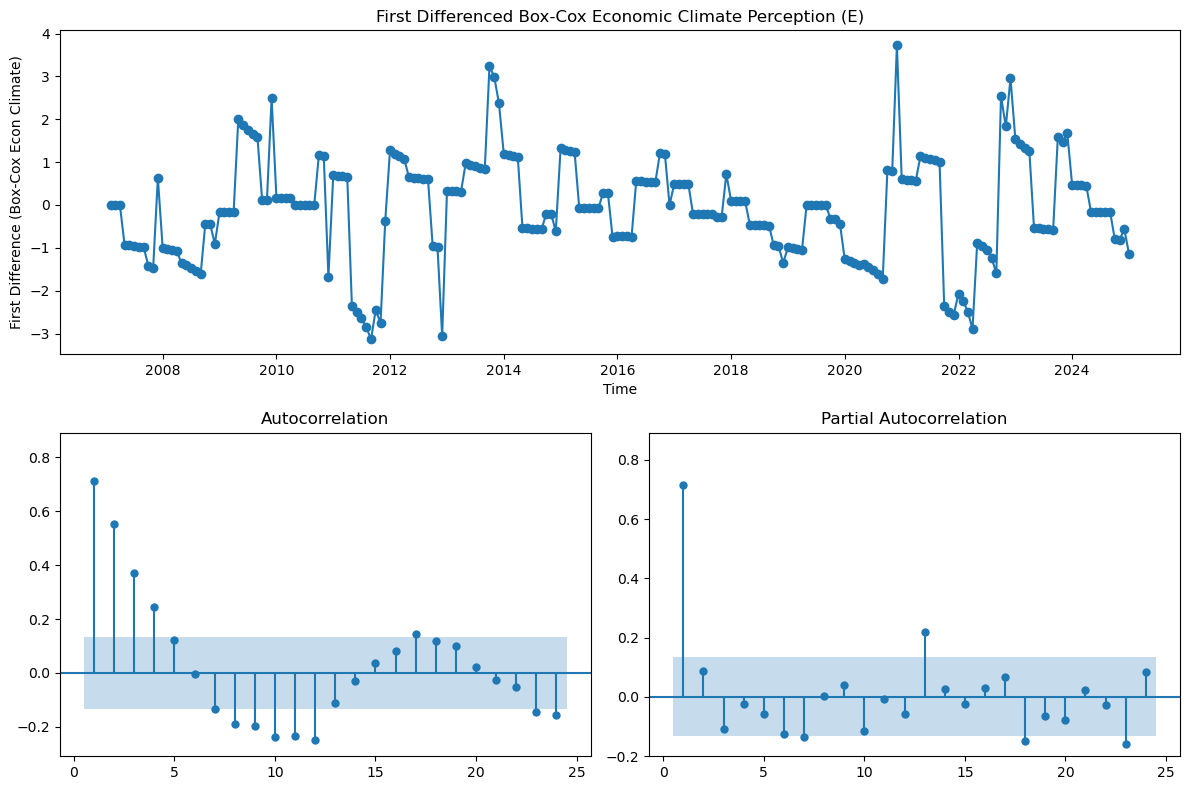

ADF Statistic (first difference): -3.6225
p-value: 0.0053
Critical Value (1%): -3.4630
Critical Value (5%): -2.8759
Critical Value (10%): -2.5744
The series is likely stationary (reject H0).


In [89]:
# Convert BoxCox Economic climate perception (E) to Series to align with time index
econ_climate_boxcox_series = pd.Series(econ_climate_boxcox, index=df.index)

# Compute first order difference
econ_climate_diff1 = econ_climate_boxcox_series.diff().dropna()

# Create plots
fig = plt.figure(figsize=(12, 8))
gs = fig.add_gridspec(2, 2)
ax1 = fig.add_subplot(gs[0, :])
ax2 = fig.add_subplot(gs[1, 0])
ax3 = fig.add_subplot(gs[1, 1])

# Time-series plot
ax1.plot(df.index[1:], econ_climate_diff1, marker="o")
ax1.set_ylabel("First Difference (Box-Cox Econ Climate)")
ax1.set_xlabel("Time")
ax1.set_title("First Differenced Box-Cox Economic Climate Perception (E)")

# ACF and PACF
plot_acf(econ_climate_diff1, ax2, zero=False, lags=24, bartlett_confint=False, auto_ylims=True)
plot_pacf(econ_climate_diff1, ax3, zero=False, lags=24, auto_ylims=True)
plt.tight_layout()
plt.show()

# ADF Test
adf_result_econ_climate = adfuller(econ_climate_diff1)

print("ADF Statistic (first difference): {:.4f}".format(adf_result_econ_climate[0]))
print("p-value: {:.4f}".format(adf_result_econ_climate[1]))
for key, value in adf_result_econ_climate[4].items():
    print(f"Critical Value ({key}): {value:.4f}")

if adf_result_econ_climate[1] < 0.05:
    print("The series is likely stationary (reject H0).")
else:
    print("The series is likely non-stationary (fail to reject H0).")

### 3. Split Data

lets do 80/10/10 split for train/validation/test sets

In [90]:
# Align index if needed (should already be DatetimeIndex)
econ_climate_diff1 = econ_climate_diff1.copy()
econ_climate_diff1.index = df.index[-len(econ_climate_diff1):]

# Calculate split indices
n = len(econ_climate_diff1)
train_end = int(n * 0.8)
val_end = int(n * 0.9)

dates = econ_climate_diff1.index
train_idx = dates[:train_end]
val_idx = dates[train_end:val_end]
test_idx = dates[val_end:]

# Split the series
econclim_train = econ_climate_diff1.loc[train_idx]
econclim_val = econ_climate_diff1.loc[val_idx]
econclim_test = econ_climate_diff1.loc[test_idx]

print(f"Train length: {len(econclim_train)}")
print(f"Validation length: {len(econclim_val)}")
print(f"Test length: {len(econclim_test)}")

Train length: 172
Validation length: 22
Test length: 22


### 4. Fit SARIMA model on the training set

### 5. evaluate model/ combine model

Willingness to buy (E)'

### 1. Data Cleaning & Transformation --> Apply Box-Cox or log transform

### 2. Stationarity Check

### 3. Split Data

lets do 80/10/10 split for train/validation/test sets

### 4. Fit SARIMA model on the training set

### 5. evaluate model/ combine model### 5. evaluate model/ combine model

# Fuel prices:
- 'Diesel price (E)', Gasoline price (E)'

### 1. Data Cleaning & Transformation --> Apply Box-Cox or log transform

### 2. Stationarity Check

### 3. Split Data

lets do 80/10/10 split for train/validation/test se

### 4. Fit SARIMA model on the training set

### 5. evaluate model/ combine model### 5. evaluate model/ combine model

### 1. Data Cleaning & Transformation --> Apply Box-Cox or log transform

### 2. Stationarity Check

### 3. Split Data


### 4. Fit SARIMA model on the training set

### 5. evaluate model/ combine model### 5. evaluate model/ combine model
